# Описание проекта

Для проведения исследования получены данные о стартапах, функционировавших в период с 1970 по 2018 годы. Дата формирования выгрузки - 2018-01-01.

Необходимо построить модель машинного обучения, которая поможет  предсказать, какие из стартапов закроются.

**План проведения исследования:**
- изучим данные;
- проведём предобработку;
- выполним исследовательский и корреляционный анализ данных;
- напишем модель МО для предсказания успешности стартапа;
- проверим модель метрикой F1-Score;
- проведём анализ важности признаков модели;
- сформулируем выводы и предложения.



---
## Загрузка и чтение данных

### Подготовка к чтению данных

In [3]:
pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.0 MB/s eta 0:00:00


In [4]:
pip install imbalanced-learn -q

In [5]:
pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.7 MB/s eta 0:00:00


In [6]:
pip install optuna-integration -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 2.3 MB/s eta 0:00:00


In [7]:
pip install phik -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 5.8 MB/s eta 0:00:00


In [8]:
pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.6 MB/s eta 0:00:00


In [9]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import optuna
import pandas as pd
import phik
import scipy.stats as st
import seaborn as sns
import shap
import warnings

from catboost import CatBoostClassifier, cv, Pool
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler
from optuna import distributions
from optuna.integration import OptunaSearchCV
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from warnings import simplefilter

Зададим настройки:

In [10]:
sns.set_theme(style="darkgrid", palette="icefire")
pd.set_option('display.max_columns', None)
pd.options.display.float_format ='{:,.3f}'.format
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

### Чтение данных

- **Датасет `kaggle_startups_train_27042024`**

Считаем тренировочные данные о стартапах и сохраним в переменную `startup_train`:

In [11]:
startup_train = pd.read_csv('/content/drive/MyDrive/DS/kaggle_startups_train_27042024.csv')

Выведем первые 20 строчек датафрейма `startup_train` на экран:



In [12]:
startup_train.head(20)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.000",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.000",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,"22,250,000.000",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,"4,300,000.000",operating,USA,NJ,Newark,Princeton,1,2011-01-20,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,"90,000,000.000",operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,"4,300,000.000",operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,"42,000,000.000",operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,"1,250,500.000",operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


- **Датасет `kaggle_startups_test_27042024`**

Считаем тренировочные данные о стартапах и сохраним в переменную `startup_test`:

In [13]:
startup_test = pd.read_csv('/content/drive/MyDrive/DS/kaggle_startups_test_27042024.csv')

Выведем первые 20 строчек датафрейма `startup_test` на экран:

In [14]:
startup_test.head(20)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,"2,819,200.000",NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,"428,257.000",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.000",USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,"4,530,000.000",CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209
5,Quickfire Games,Design|Entertainment|Games,"160,000.000",NaN,NaN,NaN,NaN,2,2013-09-01,2013-09-18,2014-09-18,1583
6,Sente Inc.,Biotechnology,"26,842,000.000",USA,CA,San Diego,Encinitas,5,2007-01-01,2009-01-31,2014-06-02,4018
7,Triosyn,Health Care|Medical|Therapeutics,"4,000,000.000",NaN,NaN,NaN,NaN,1,2002-07-22,2003-06-02,2003-06-02,5642
8,Urgent.ly,Software,"8,710,000.000",USA,VA,"Washington, D.C.",Sterling,3,2013-01-01,2014-04-17,2015-09-29,1826
9,Map Decisions,Software,"13,200.000",USA,PA,Allentown,Bethlehem,1,2012-05-15,2013-08-09,2013-08-09,2057


### Изучение датафреймов

Изучим структуру и полноту полученных данных.

In [15]:
# функция для вывода методов info() и msno.bar()
def info (df):
    display(df.info())
    msno.bar(df)

- **Датафрейм `*startup_train*`**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52513 non-null  object 
 1   category_list      50049 non-null  object 
 2   funding_total_usd  42445 non-null  float64
 3   status             52514 non-null  object 
 4   country_code       47013 non-null  object 
 5   state_code         45752 non-null  object 
 6   region             46156 non-null  object 
 7   city               46156 non-null  object 
 8   funding_rounds     52514 non-null  int64  
 9   founded_at         52514 non-null  object 
 10  first_funding_at   52514 non-null  object 
 11  last_funding_at    52514 non-null  object 
 12  closed_at          4915 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

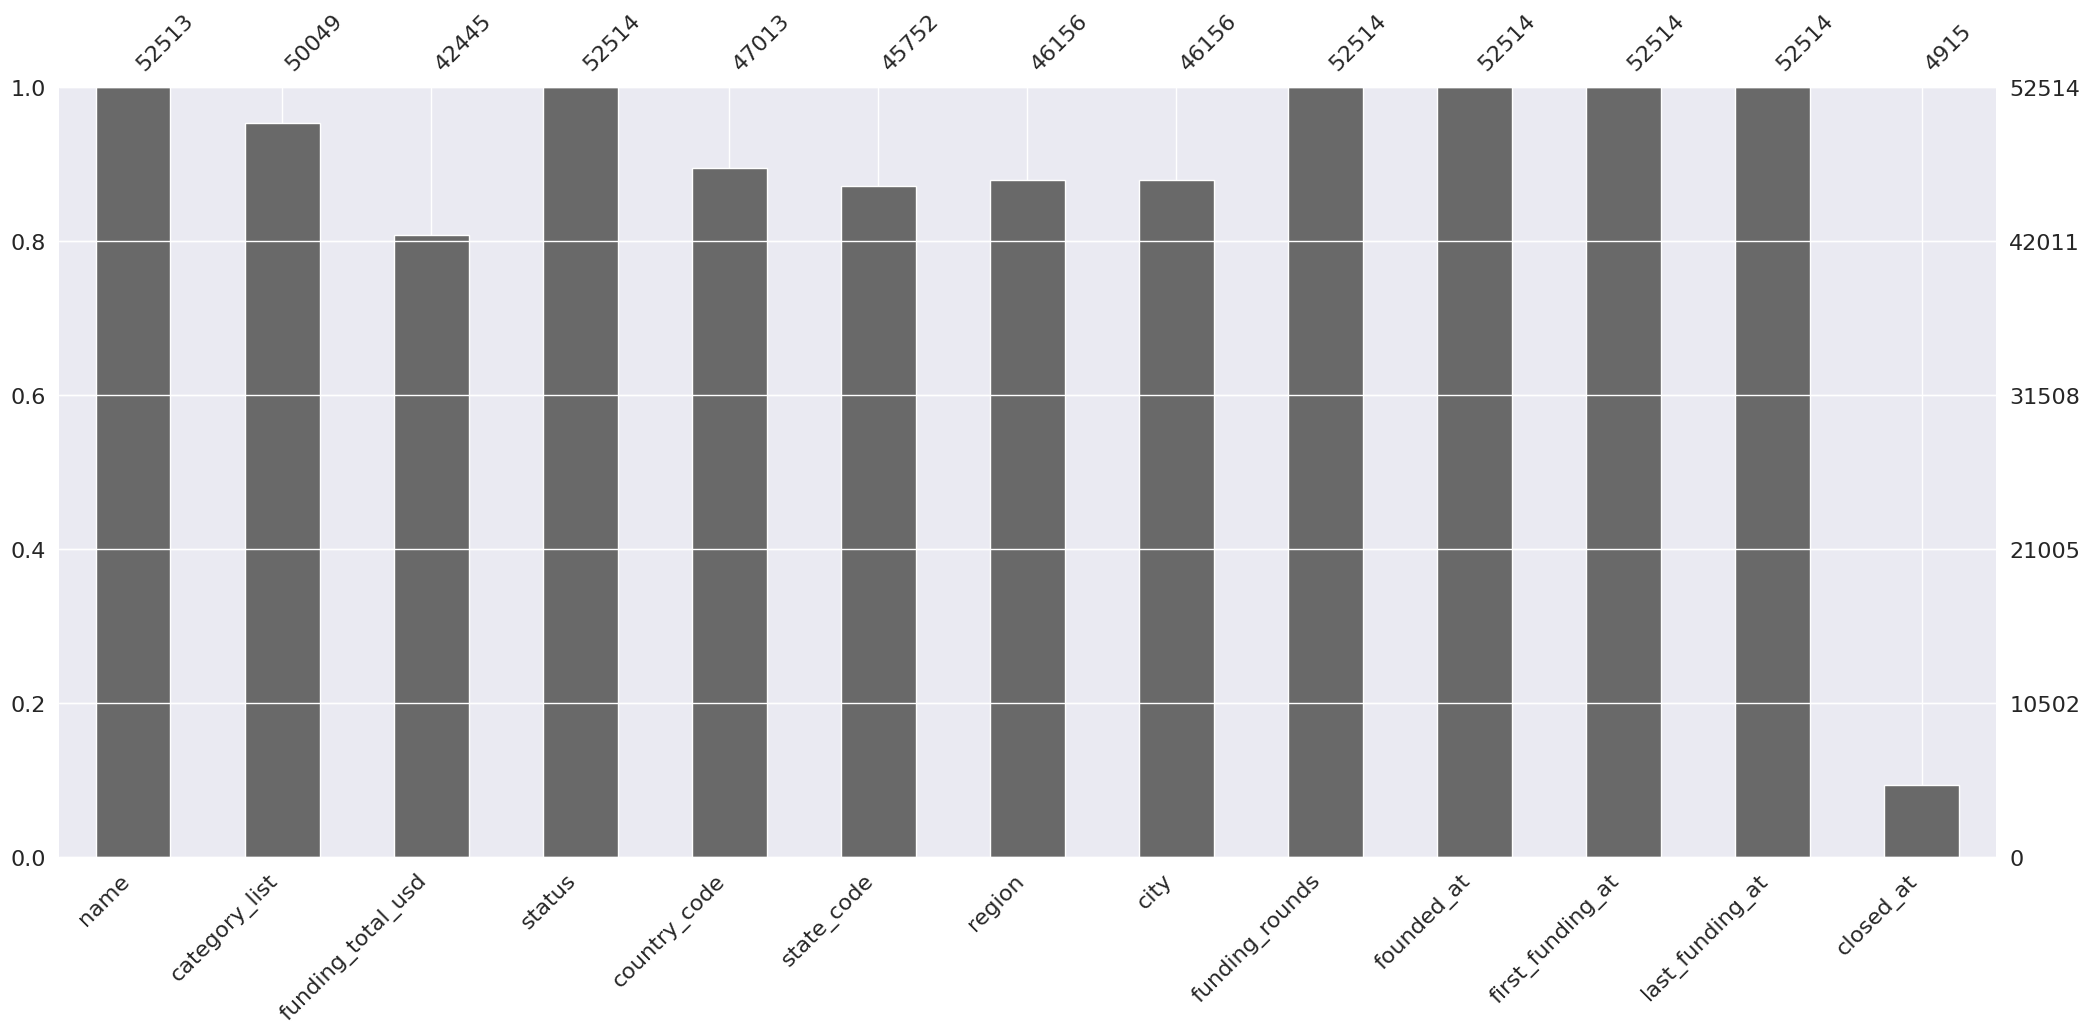

In [16]:
info(startup_train)

- **Датафрейм `*startup_test*`**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   founded_at         13125 non-null  object 
 9   first_funding_at   13125 non-null  object 
 10  last_funding_at    13125 non-null  object 
 11  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 1.2+ MB


None

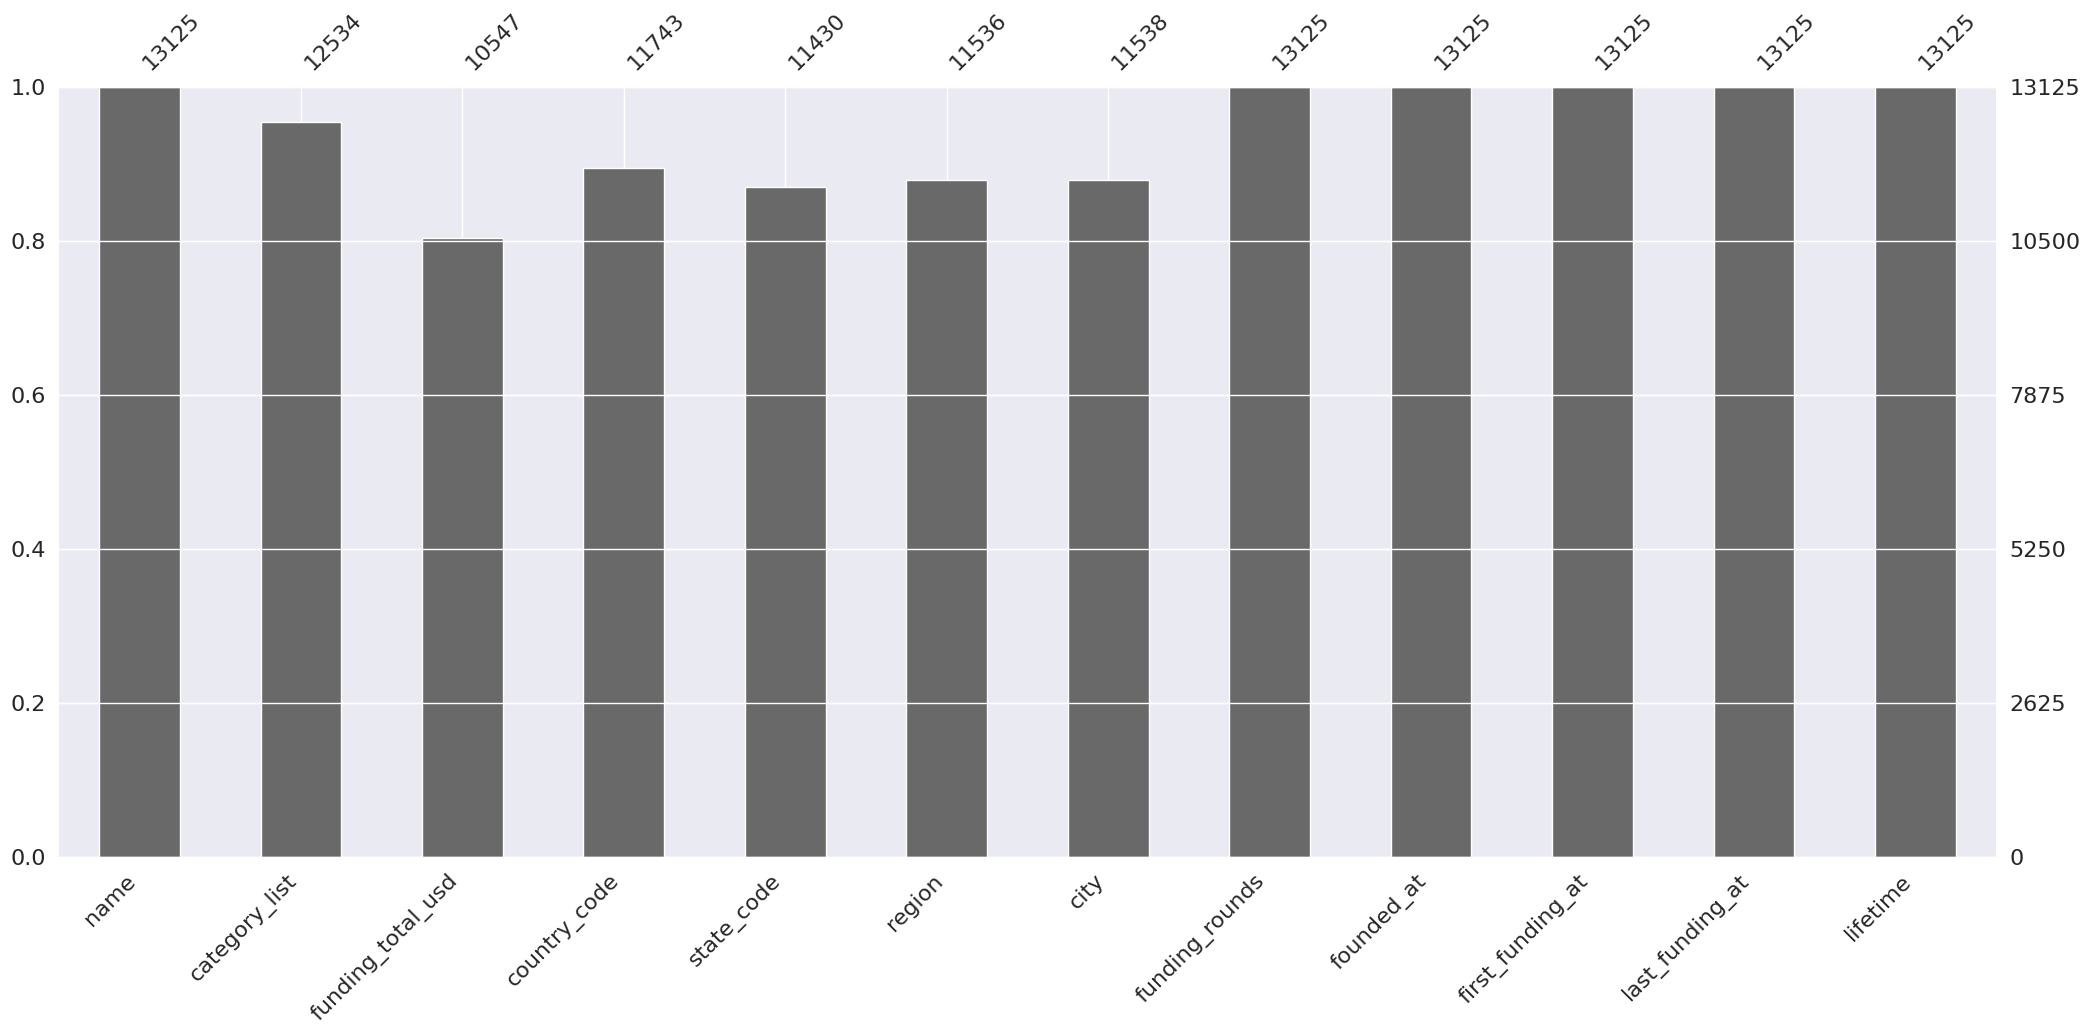

In [17]:
info(startup_test)

**Вывод:**

Полученные датафреймы содержат следующие данные:

  * `name` — название стартапа;
  * `category_list` — список категорий, к которым относится стартап;
  * `funding_total_usd` — общая сумма финансирования (в USD);
  * `status` — cтатус стартапа (закрыт или действующий) - целевой признак;
  * `country_code` — код страны;
  * `state_code` — код штата;
  * `region` — регион;
  * `city` — город;
  * `funding_rounds` — количество раундов финансирования;
  * `founded_at` — дата основания;
  * `first_funding_at` — дата первого раунда финансирования;
  * `last_funding_at` — дата последнего раунда финансирования;
  * `closed_at` — дата закрытия стартапа (если применимо);
  * `lifetime` — время существования стартапа в днях.

Предварительно можно утверждать, что данных достаточно для проведения исследования.
    
В датасетах имеются пропущенные значения, необходимо подробнее изучить тип имеющихся данных, а также в данных могут присутствовать дубликаты.

---

## Предобработка данных

### Тип данных


Убедимся, что в датафреймах корретный тип данных.

####  **датафрейм `startup_train`**

In [18]:
startup_train.dtypes

name                  object
category_list         object
funding_total_usd    float64
status                object
country_code          object
state_code            object
region                object
city                  object
funding_rounds         int64
founded_at            object
first_funding_at      object
last_funding_at       object
closed_at             object
dtype: object

Изменим тип данных в следующих столбцах:
- `founded_at`, `first_funding_at`, `last_funding_at` и `closed_at` переведём в **datetime**

In [19]:
# меняем тип данных в выбранных столбцах
startup_train['founded_at'] = pd.to_datetime(startup_train['founded_at'], format = '%Y-%m-%d')
startup_train['first_funding_at'] = pd.to_datetime(startup_train['first_funding_at'], format = '%Y-%m-%d')
startup_train['last_funding_at'] = pd.to_datetime(startup_train['last_funding_at'], format = '%Y-%m-%d')
startup_train['closed_at'] = pd.to_datetime(startup_train['closed_at'], format = '%Y-%m-%d')

# проверяем результат:
startup_train.dtypes

name                         object
category_list                object
funding_total_usd           float64
status                       object
country_code                 object
state_code                   object
region                       object
city                         object
funding_rounds                int64
founded_at           datetime64[ns]
first_funding_at     datetime64[ns]
last_funding_at      datetime64[ns]
closed_at            datetime64[ns]
dtype: object

- бинаризируем целевой признак `status`:

In [20]:
# бинаризируем признак
startup_train['status'] = [1 if i == 'closed' else 0 for i in startup_train['status']]

# проверим результат:
startup_train['status'].value_counts()

status
0    47599
1     4915
Name: count, dtype: int64

#### **датафрейм `startup_test`**

In [21]:
startup_test.dtypes

name                  object
category_list         object
funding_total_usd    float64
country_code          object
state_code            object
region                object
city                  object
funding_rounds         int64
founded_at            object
first_funding_at      object
last_funding_at       object
lifetime               int64
dtype: object

Изменим тип данных в следующих столбцах:
- `founded_at`, `first_funding_at` и `last_funding_at` переведём в **datetime**

In [22]:
# меняем тип данных в выбранных столбцах
startup_test['founded_at'] = pd.to_datetime(startup_test['founded_at'], format = '%Y-%m-%d')
startup_test['first_funding_at'] = pd.to_datetime(startup_test['first_funding_at'], format = '%Y-%m-%d')
startup_test['last_funding_at'] = pd.to_datetime(startup_test['last_funding_at'], format = '%Y-%m-%d')

# проверим результат:
startup_test.dtypes

name                         object
category_list                object
funding_total_usd           float64
country_code                 object
state_code                   object
region                       object
city                         object
funding_rounds                int64
founded_at           datetime64[ns]
first_funding_at     datetime64[ns]
last_funding_at      datetime64[ns]
lifetime                      int64
dtype: object

**Вывод**

Все столбцы в датафреймах содержат корректный тип данных:
- количественные столбцы имеют тип `float64`;
-  столбцы, содержащие дату, имеют тип `datetime64`;
-  категориальные - тип `object`.

### Проверка пропусков

Гистограммы `msno` показали наличие пропущенных значений в датафреймах, изучим их подробнее.

#### **датафрейм `startup_train`**

In [23]:
#считаем кол-во пропущенных значений
startup_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

In [24]:
#считаем кол-во пропуков в столбце в процентах
for col in startup_train.columns:
    pct_missing = np.mean(startup_train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

name - 0%
category_list - 5%
funding_total_usd - 19%
status - 0%
country_code - 10%
state_code - 13%
region - 12%
city - 12%
funding_rounds - 0%
founded_at - 0%
first_funding_at - 0%
last_funding_at - 0%
closed_at - 91%


**Вывод:**

Всего в датафрейме `startup_train` 52514 записей.
Столбцы, в которых пропущенные значения составляют 50% и более, отсутствуют - на данном этапе нет необходимости удалять признаки из-за пропущенных значений.

Столбец `closed_at` - дата закрытия, наличие пропуска означает, что стартап не был закрыт на момент получения выгрузки.
    
Пропущенные значения остальных столбцов обработаем по следующему алгоритму:

- `country_code`, `state_code`, `region`, `city` - по возможности заполним пропущенные значения по данным в соседних столбцах, оставшиеся пропуски заполним категорией-заглушкой;
- `funding_total_usd` - заполним медианным значением;
- `category_list` - заполним пропущенные значения категорией-заглушкой, чтобы для построения прогноза модель использовала только достоверные данные.

---
- **Признак `country_code`**

Пропущенные значения в данном столбце обработаем по принципу "от частного к общему": если имеются данные о штате, регионе или городе стартапа, определим по ним страну.

In [25]:
startup_train[startup_train['country_code'].isna()
              & (pd.notna(startup_train['city'])
              | pd.notna(startup_train['region'])
              | pd.notna(startup_train['state_code']))]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


В столбцах `state_code`, `region`, `city` отсутствуют значения, которые можно было бы использовать для заполнения пропусков.
Заполним пропущенные значения категорией-заглушкой `Unknown`:

In [127]:
# заполним пропуски
startup_train['country_code'] = startup_train['country_code'].fillna('Unknown')

# проверим результат
startup_train['country_code'].isna().sum()

0

---
- **Признак `state_code`**

Проверим наличие данных о регионе и городе расположения стартапа, после чего используем их для заполнения кода штата.

In [27]:
state_code_train = startup_train[startup_train['state_code'].isna()
              & (pd.notna(startup_train['city'])
              | pd.notna(startup_train['region']))]

state_code_train['country_code']

300      SGP
491      VNM
599      SGP
703      SGP
848      HKG
        ... 
52115    SGP
52360    SGP
52380    HKG
52405    MLT
52506    HKG
Name: country_code, Length: 638, dtype: object

Заполним выявленные пропущенные значения столбца `state_code` по данным столбца `country_code`:

In [28]:
startup_train['state_code'] = startup_train['state_code'].fillna(state_code_train['country_code'])

Проверим результат:

In [29]:
startup_train['state_code'].isna().sum()

6124

Количество пропущенных значений уменьшилось на 638 записей.

---
- **Признак `region`**

Проверим наличие  данных о городе расположения стартапа для пропущенных значений региона:

In [30]:
startup_train[startup_train['region'].isna()
              & pd.notna(startup_train['city'])]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


В столбце `city` отсутствуют значения, которые можно было бы использовать для заполнения пропусков.
Заполним пропущенные значения категорией-заглушкой в шаге Pipeline в случае использования признака для обучения модели.

---

- **Признак `funding_total_usd`**

Заполним пропуски медианным значением.

In [31]:
#заполняем пропуски
startup_train["funding_total_usd"] = startup_train["funding_total_usd"].fillna(
    startup_train["funding_total_usd"].median()
)

#проверяем результат
startup_train["funding_total_usd"].isna().sum()

0

Пропущенные значения обработаны.

---

- **Признак `category_list`**

Заполним пропущенные категории значением-заглушкой `Unknown`:

In [32]:
#заполняем пропуски
startup_train['category_list'] = startup_train['category_list'].fillna('Unknown')

#проверяем результат
startup_train["category_list"].isna().sum()

0

Пропущенные значения обработаны.

---
#### **датафрейм `startup_test`**

In [33]:
#считаем кол-во пропущенных значений
startup_test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

In [34]:
#считаем кол-во пропуков в столбце в процентах
for col in startup_test.columns:
    pct_missing = np.mean(startup_test[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

name - 0%
category_list - 5%
funding_total_usd - 20%
country_code - 11%
state_code - 13%
region - 12%
city - 12%
funding_rounds - 0%
founded_at - 0%
first_funding_at - 0%
last_funding_at - 0%
lifetime - 0%


**Вывод:**

Всего в датафрейме `startup_test` 13125 записей.
Столбцы, в которых пропущенные значения составляют 50% и более, отсутствуют - на данном этапе нет необходимости удалять признаки из-за пропущенных значений.

Столбец `closed_at` - дата закрытия, наличие пропуска означает, что стартап не был закрыт на момент получения выгрузки.
    
Пропущенные значения остальных столбцов обработаем по следующему алгоритму:

- `country_code`, `state_code`, `region`, `city` - по возможности заполним пропущенные значения при наличии данных в соседних столбцах. Оставшиеся пропуски заполним категорией-заглушкой;
- `funding_total_usd` - заполним медианным значением;
- `category_list` - заполним пропущенные значения категорией-заглушкой, чтобы для построения прогноза модель использовала только достоверные данные.

- **Признак `country_code`**

Проверим, имеются ли данные о штате, регионе или городе стартапа:

In [35]:
startup_test[startup_test['country_code'].isna()
              & (pd.notna(startup_test['city'])
              | pd.notna(startup_test['region'])
              | pd.notna(startup_test['state_code']))]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime


В столбцах `state_code`, `region`, `city` отсутствуют значения, которые можно было бы использовать для заполнения пропусков.
Заполним пропущенные значения категорией-заглушкой `Unknown`:

In [36]:
startup_test['country_code'] = startup_test['country_code'].fillna('Unknown')

- **Признак `state_code`**

Проверим наличие данных о регионе и городе расположения стартапа, после чего используем их для заполнения кода штата.

In [37]:
state_code_test = startup_test[startup_test['state_code'].isna()
              & (pd.notna(startup_test['city'])
              | pd.notna(startup_test['region']))]

state_code_test

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
128,Shoplins,Coupons|CRM|Loyalty Programs|Mobile,"325,000.000",URY,NaN,Montevideo,Montevideo,2,2012-01-06,2012-01-06,2012-05-01,2187
129,kibow,Entertainment|Services|Sports,"840,000.000",SGP,NaN,Singapore,Singapore,1,2011-07-14,2015-04-15,2015-04-15,2363
145,CloudDesk,Mobile Commerce,"418,000.000",SGP,NaN,Singapore,Singapore,1,2013-01-01,2015-08-18,2015-08-18,1826
207,Ahometo,E-Commerce,NaN,VNM,NaN,Ho Chi Minh,Ho Chi Minh City,1,2012-12-01,2014-01-02,2014-01-02,1857
409,UeeeU.com,E-Commerce,"727,000.000",SGP,NaN,Singapore,Singapore,1,2006-09-22,2008-03-18,2008-03-18,1227
...,...,...,...,...,...,...,...,...,...,...,...,...
12526,Mobilitrix,Mobile,"80,000.000",ZAF,NaN,Cape Town,Cape Town,2,2006-02-05,2007-02-01,2007-09-01,4348
12546,Intuitive Creations,Medical Devices,"475,000.000",SGP,NaN,Singapore,Singapore,1,2011-08-23,2013-03-01,2013-03-01,2323
12871,OurCam,Messaging|Mobile|Photography,"41,250.000",HKG,NaN,Hong Kong,Hong Kong,1,2014-08-11,2015-08-01,2015-08-01,1239
13036,01Games Technology,Games,"41,250.000",HKG,NaN,Hong Kong,Hong Kong,1,2013-03-29,2014-07-01,2014-07-01,1739


Заполним выявленные пропущенные значения столбца `state_code` по данным столбца `country_code`:

In [38]:
#Заполним пропуски
startup_test['state_code'] = startup_test['state_code'].fillna(state_code_test['country_code'])

#Проверим результат
startup_test['state_code'].isna().sum()

1528

Количество пропущенных значений уменьшилось на 167 записей.

- **Признак `region`**

Проверим наличие  данных о городе расположения стартапа для пропущенных значений региона:

In [39]:
startup_test[startup_test['region'].isna()
              & pd.notna(startup_test['city'])]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
2300,Readify,Software,"20,996,540.000",AUS,7,NaN,Docklands,2,2001-01-01,2013-10-02,2014-11-10,6209
6473,Red Crow,Security,"20,000.000",PSE,WE,NaN,Ramallah,1,2012-12-01,2014-08-08,2014-08-08,1857


Заполним выявленные пропущенные значения столбца `region` по данным столбца `city`:
- городу Docklands присвоим регион Melbourne;
- городу Ramallah -  Central West Bank.

In [40]:
#Заполним пропуски:
startup_test.loc[startup_test['city'] == 'Docklands', 'region'] = 'Melbourne'
startup_test.loc[startup_test['city'] == 'Ramallah', 'region'] = 'Central West Bank'

#Проверим результат:
startup_test.loc[startup_test['city'].isin(['Ramallah', 'Docklands'])]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
2300,Readify,Software,"20,996,540.000",AUS,7,Melbourne,Docklands,2,2001-01-01,2013-10-02,2014-11-10,6209
6473,Red Crow,Security,"20,000.000",PSE,WE,Central West Bank,Ramallah,1,2012-12-01,2014-08-08,2014-08-08,1857


Пропуски обработаны.

- **Признак `funding_total_usd`**

Заполним пропуски медианным значением.

In [41]:
#заполняем пропуски
startup_test["funding_total_usd"] = startup_test["funding_total_usd"].fillna(
    startup_test["funding_total_usd"].median()
)

#проверяем результат
startup_test["funding_total_usd"].isna().sum()

0

Пропуски обработаны.

- **Признак `category_list`**

Заполним пропущенные категории значением-заглушкой `Unknown`:

In [42]:
#заполняем пропуски
startup_test['category_list'] = startup_test['category_list'].fillna('Unknown')

#проверяем результат
startup_test["category_list"].isna().sum()

0

**Вывод**

Пропущенные значения изучены и обработаны, оставшиеся пропуски заполним в шаге pipeline по выбранному алгоритму.


### Проверка явных дубликатов

Проверим наличие явных дубликатов в датафреймах.


#### **датафрейм `startup_train`**

In [43]:
startup_train.duplicated().sum()

0

Явные дубликаты отсутствуют.

#### **датафрейм `startup_test`**

In [44]:
startup_test.duplicated().sum()

0

Явные дубликаты отсутствуют.

### Проверка неявных дубликатов

Проверим категориальные столбцы датафреймов на наличие неявных дубликатов.

####  **датафрейм `startup_train`**

Изучим количество уникальных значений в датафрейме:

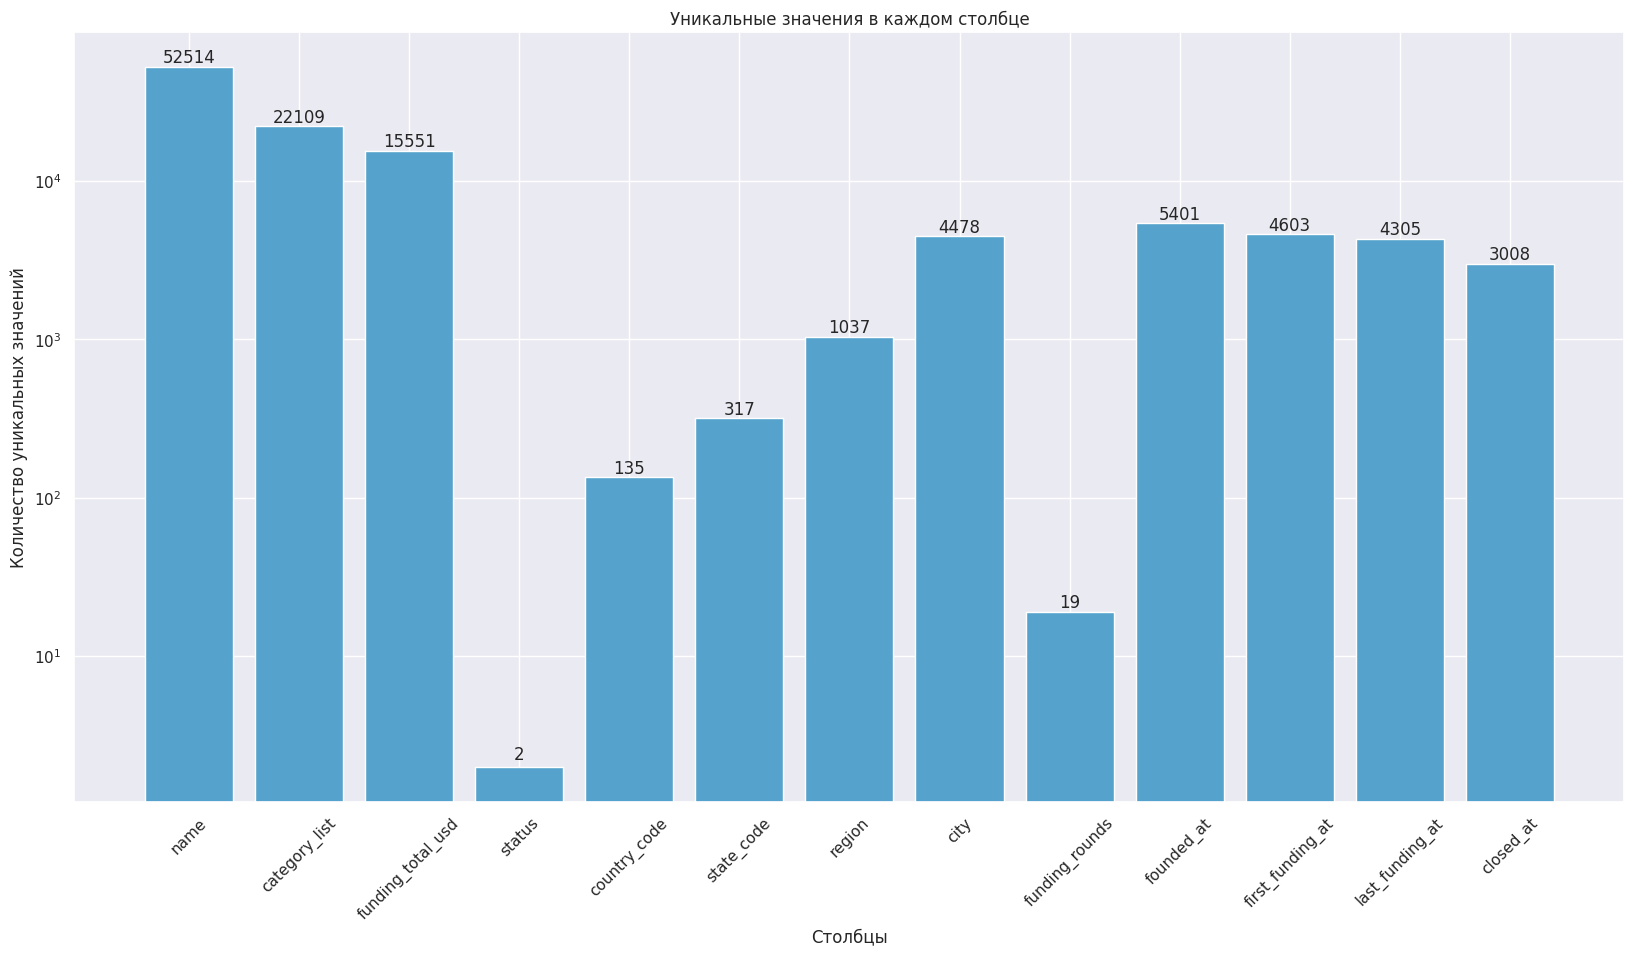

In [45]:
# создаем список для хранения количества уникальных значений в каждом столбце
unique_values_count = []

# перебираем все столбцы датафрейма
for column in startup_train.columns:
    unique_values_count.append(len(startup_train[column].unique()))

# строим столбчатую гистограмму
plt.figure(figsize=(20, 10))
bars = plt.bar(startup_train.columns, unique_values_count,  log=True)
plt.xlabel('Столбцы')
plt.ylabel('Количество уникальных значений')
plt.title('Уникальные значения в каждом столбце')
plt.xticks(rotation=45)

# добавляем количество уникальных значений над каждым баром
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

plt.show()

В датафрейме присутствуют категориальные столбцы с высокой вариативностью, изучим подробнее каждый из них.

- признак `category_list`

In [46]:
# считаем кол-во уникальных значений в столбце
startup_train['category_list'].nunique()

22109

Признак содержит 22108 уникальных значений, что говорит о высокой кардинальности признака.

Чтобы избежать высокой размерности после кодирования признака, уменьшим количество уникальных категорий. Для этого извлечём признаки из столбца с использованием TF-IDF.

Обучим `TfidfVectorizer()` на категориях деятельности стартапов:

In [47]:
# Функция, разделяющая текст в ячейке по символу "|"
def custom_tokenizer(text):
    return text.split('|')

# Создаем объект TfidfVectorizer с использованием функции custom_tokenizer()
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
vectorizer.fit(startup_train['category_list'])

# Применяем обученный объект TfidfVectorizer() к тренировочной выборке:
train_categories = vectorizer.transform(startup_train['category_list'])

#Проверяем результат:
print('Матрица `train_categories`:')
train_categories

Матрица `train_categories`:


<52514x855 sparse matrix of type '<class 'numpy.float64'>'
	with 123459 stored elements in Compressed Sparse Row format>

Получили разреженную матрицу, содержащую 52514 строк и 855 признаков, переведём полученную матрицу в датафрейм:

In [48]:
#Создаём датафрейм
train_categories_df = pd.DataFrame.sparse.from_spmatrix(
    train_categories, columns=vectorizer.get_feature_names_out()
)

#Проверяем результат:
train_categories_df.head()

,3d,3d printing,3d technology,accounting,active lifestyle,ad targeting,adaptive equipment,advanced materials,adventure travel,advertising,advertising exchanges,advertising networks,advertising platforms,advice,aerospace,agriculture,air pollution control,algorithms,all markets,all students,alternative medicine,alumni,analytics,android,angels,animal feed,anything capital intensive,app discovery,app marketing,app stores,application performance monitoring,application platforms,apps,aquaculture,architecture,archiving,art,artificial intelligence,artists globally,assisitive technology,assisted living,auctions,audio,audiobooks,augmented reality,auto,automated kiosk,automotive,b2b,b2b express delivery,babies,baby accessories,baby boomers,baby safety,banking,batteries,beauty,bicycles,big data,big data analytics,billing,bio-pharm,biofuels,bioinformatics,biomass power generation,biometrics,biotechnology,biotechnology and semiconductor,bitcoin,blogging platforms,boating industry,bpo services,brand marketing,brewing,bridging online and offline,broadcasting,brokers,browser extensions,building owners,building products,business analytics,business development,business information systems,business intelligence,business productivity,business services,business travelers,cable,cad,call center automation,cannabis,carbon,career management,career planning,cars,casual games,cause marketing,celebrity,certification test,charities,charity,charter schools,chat,chemicals,child care,china internet,civil engineers,classifieds,clean energy,clean technology,clean technology it,clinical trials,cloud computing,cloud data services,cloud gaming,cloud infrastructure,cloud management,cloud security,cloud-based music,coffee,collaboration,collaborative consumption,collectibles,college campuses,college recruiting,colleges,comics,commercial real estate,commercial solar,commodities,communications hardware,communications infrastructure,communities,comparison shopping,computer vision,computers,concentrated solar power,concerts,console gaming,construction,consulting,consumer behavior,consumer electronics,consumer goods,consumer internet,consumer lending,consumers,contact centers,contact management,content,content creators,content delivery,content discovery,content syndication,contests,cooking,corporate it,corporate training,corporate wellness,cosmetic surgery,cosmetics,coupons,coworking,craft beer,creative,creative industries,credit,credit cards,crm,crowdfunding,crowdsourcing,cryptocurrency,curated web,custom retail,customer service,customer support tools,cyber,cyber security,data center automation,data center infrastructure,data centers,data integration,data mining,data privacy,data security,data visualization,databases,debt collecting,deep information technology,defense,delivery,demographies,dental,design,designers,developer apis,developer tools,development platforms,diabetes,diagnostics,dietary supplements,digital entertainment,digital media,digital rights management,digital signage,direct advertising,direct marketing,direct sales,discounts,displays,disruptive models,distribution,distributors,diving,diy,doctors,document management,dod/military,domains,drones,e-books,e-commerce,e-commerce platforms,early stage it,early-stage technology,east africa,ebooks,eda tools,ediscovery,edtech,education,educational games,edutainment,elder care,elderly,electric vehicles,electrical distribution,electronic health records,electronics,email,email marketing,email newsletters,embedded hardware and software,emerging markets,employer benefits programs,employment,energy,energy efficiency,energy it,energy management,energy storage,engineering firms,english-speaking,enterprise 2.0,enterprise application,enterprise hardware,enterprise purchasing,enterprise resource planning,enterprise search,enterprise security,enterprise software,enterprises,entertainment,entertainment industry,entrepreneur,environmental innovation,estimation and quoting,event management,events,exercise,experience design,eyewear,

Получен датафрейм, содержащий столбцы-индикаторы категории деятельности стартапов.

Данные изменения помогут снизить кол-во уникальных категорий, что может улучшить качество модели.

---
- признак `status`

In [49]:
# считаем кол-во уникальных значений в столбце
startup_train['status'].value_counts()

status
0    47599
1     4915
Name: count, dtype: int64

**Вывод:**

Целевой ризнак `status` не сбалансирован, учтём это при формировании обучающей выборки для модели.

---
- признаки `country_code`,  `state_code`,  `region` и `city`

In [50]:
# считаем кол-во уникальных значений в столбце
startup_train['country_code'].nunique()

135

In [51]:
# считаем кол-во уникальных значений в столбце
startup_train['state_code'].nunique()

316

Проверим признак `state_code` на уникальность, так как коды штатов могут совпадать в разных странах:

Проверим значения столбца на уникальность, так как код штата в разных странах может совпадать:

In [52]:
#выведем уникальный список стран, в которых есть регион с кодом "7"
startup_train[startup_train['state_code'] == '7']['country_code'].unique()

array(['IND', 'AUS', 'NLD', 'ARG', 'IRL', 'ITA', 'CHE', 'DEU', 'GTM',
       'PRT', 'CHN', 'CRI', 'MEX', 'AUT', 'ESP', 'RUS', 'NOR', 'IDN',
       'BEL', 'JAM', 'UKR'], dtype=object)

Значения в столбце `state_code` не уникальны и совпадают в разных странах.

Удалим данный столбец, так как он не несёт в себе ценной информации.

In [53]:
del startup_train['state_code']

#Проверим результат
startup_train.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'region', 'city', 'funding_rounds', 'founded_at', 'first_funding_at',
       'last_funding_at', 'closed_at'],
      dtype='object')

Столбец `state_code` успешно удалён.

In [54]:
# считаем кол-во уникальных значений в столбце
startup_train['region'].nunique()

1036

In [55]:
# считаем кол-во уникальных значений в столбце
startup_train['city'].nunique()

4477

**Вывод**

- признак `country_code` содержит 134 уникальных значения;
- признак `region` - 1036 значений;
- признак `city` - 4477 значений.

---
####  **датафрейм `startup_test`**

Изучим количество уникальных значений в датафрейме:

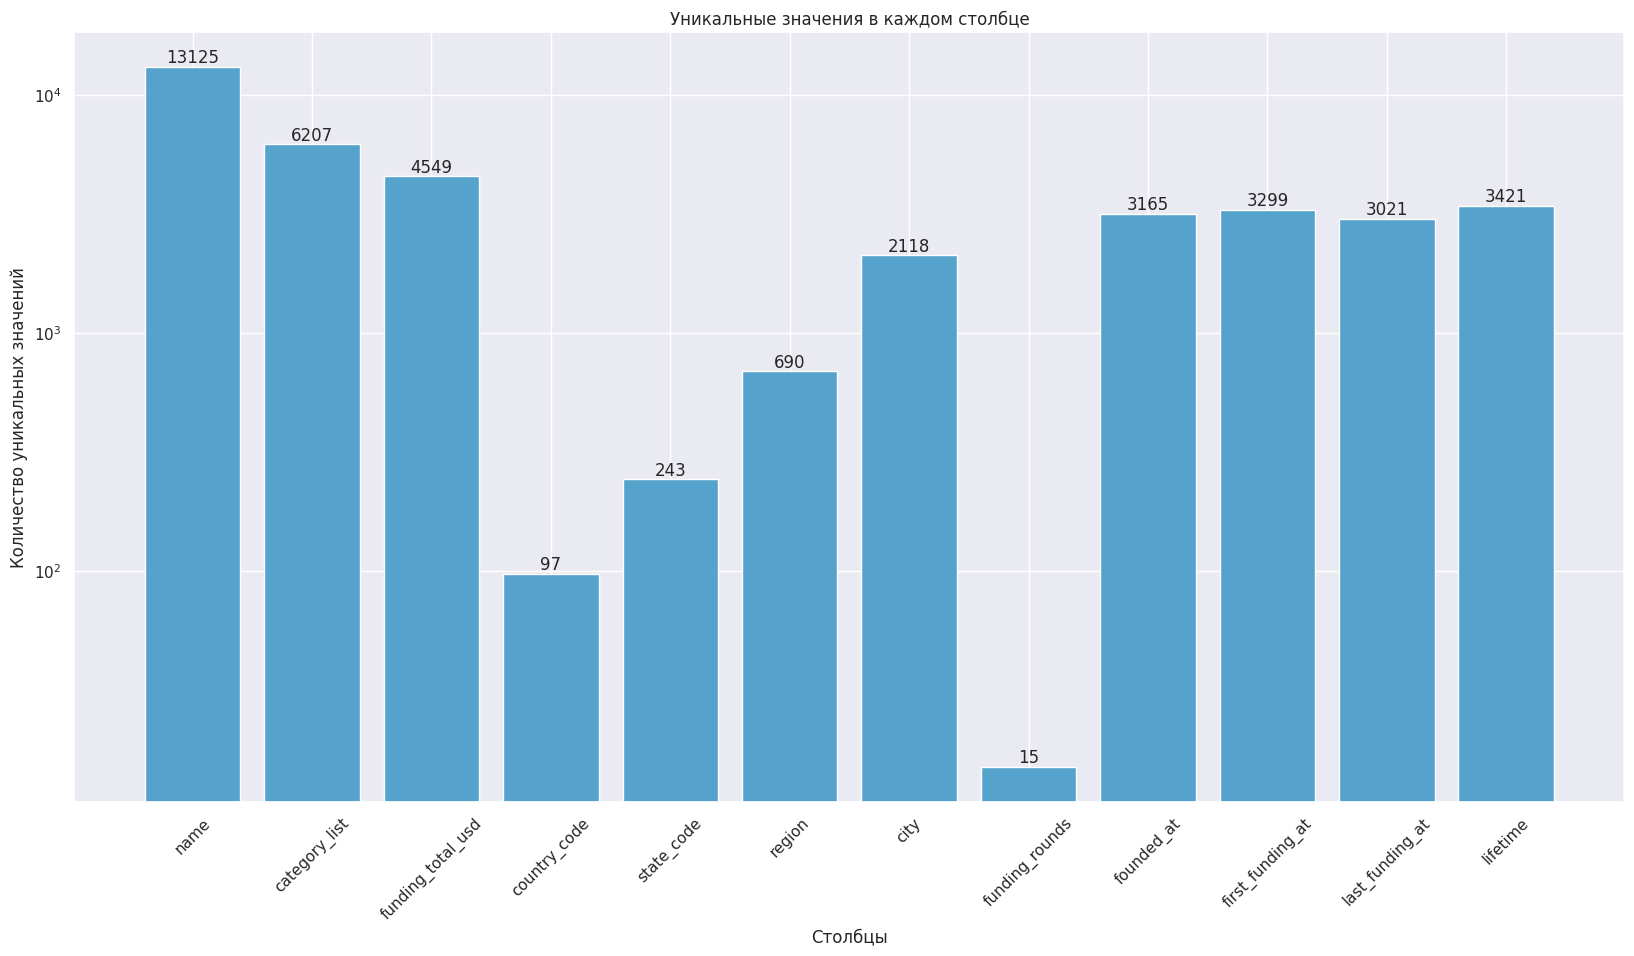

In [56]:
# создаем список для хранения количества уникальных значений в каждом столбце
unique_values_count = []

# перебираем все столбцы датафрейма
for column in startup_test.columns:
    unique_values_count.append(len(startup_test[column].unique()))

# строим столбчатую гистограмму
plt.figure(figsize=(20, 10))
bars = plt.bar(startup_test.columns, unique_values_count,  log=True)
plt.xlabel('Столбцы')
plt.ylabel('Количество уникальных значений')
plt.title('Уникальные значения в каждом столбце')
plt.xticks(rotation=45)

# добавляем количество уникальных значений над каждым баром
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

plt.show()

В датафрейме также присутствуют категориальные столбцы с высокой вариативностью, изучим подробнее каждый из них.

- признак `category_list`

In [57]:
# считаем кол-во уникальных значений в столбце
startup_test['category_list'].nunique()

6207

Признак содержит 6206 уникальных значений, что говорит о высокой кардинальности.

Обработаем стобец `category_list` аналогично датафрейму `startup_train`: извлечём признаки из столбца с использованием TF-IDF.

Применим обученный объект `TfidfVectorizer()` к тестовой выборке:

In [58]:
# применяем обученный объект TfidfVectorizer() к тестовой выборке:
test_categories = vectorizer.transform(startup_test['category_list'])

#Проверим результат:
print('Матрица `test_categories`:')
test_categories

Матрица `test_categories`:


<13125x855 sparse matrix of type '<class 'numpy.float64'>'
	with 30871 stored elements in Compressed Sparse Row format>

Получили разреженную матрицу, содержащую 13125 строк и 855 признаков, переведём полученную матрицу в датафрейм:

In [59]:
#создаём датафрейм
test_categories_df = pd.DataFrame.sparse.from_spmatrix(
    test_categories, columns=vectorizer.get_feature_names_out()
)

#проверяем результат
test_categories_df.head()

,3d,3d printing,3d technology,accounting,active lifestyle,ad targeting,adaptive equipment,advanced materials,adventure travel,advertising,advertising exchanges,advertising networks,advertising platforms,advice,aerospace,agriculture,air pollution control,algorithms,all markets,all students,alternative medicine,alumni,analytics,android,angels,animal feed,anything capital intensive,app discovery,app marketing,app stores,application performance monitoring,application platforms,apps,aquaculture,architecture,archiving,art,artificial intelligence,artists globally,assisitive technology,assisted living,auctions,audio,audiobooks,augmented reality,auto,automated kiosk,automotive,b2b,b2b express delivery,babies,baby accessories,baby boomers,baby safety,banking,batteries,beauty,bicycles,big data,big data analytics,billing,bio-pharm,biofuels,bioinformatics,biomass power generation,biometrics,biotechnology,biotechnology and semiconductor,bitcoin,blogging platforms,boating industry,bpo services,brand marketing,brewing,bridging online and offline,broadcasting,brokers,browser extensions,building owners,building products,business analytics,business development,business information systems,business intelligence,business productivity,business services,business travelers,cable,cad,call center automation,cannabis,carbon,career management,career planning,cars,casual games,cause marketing,celebrity,certification test,charities,charity,charter schools,chat,chemicals,child care,china internet,civil engineers,classifieds,clean energy,clean technology,clean technology it,clinical trials,cloud computing,cloud data services,cloud gaming,cloud infrastructure,cloud management,cloud security,cloud-based music,coffee,collaboration,collaborative consumption,collectibles,college campuses,college recruiting,colleges,comics,commercial real estate,commercial solar,commodities,communications hardware,communications infrastructure,communities,comparison shopping,computer vision,computers,concentrated solar power,concerts,console gaming,construction,consulting,consumer behavior,consumer electronics,consumer goods,consumer internet,consumer lending,consumers,contact centers,contact management,content,content creators,content delivery,content discovery,content syndication,contests,cooking,corporate it,corporate training,corporate wellness,cosmetic surgery,cosmetics,coupons,coworking,craft beer,creative,creative industries,credit,credit cards,crm,crowdfunding,crowdsourcing,cryptocurrency,curated web,custom retail,customer service,customer support tools,cyber,cyber security,data center automation,data center infrastructure,data centers,data integration,data mining,data privacy,data security,data visualization,databases,debt collecting,deep information technology,defense,delivery,demographies,dental,design,designers,developer apis,developer tools,development platforms,diabetes,diagnostics,dietary supplements,digital entertainment,digital media,digital rights management,digital signage,direct advertising,direct marketing,direct sales,discounts,displays,disruptive models,distribution,distributors,diving,diy,doctors,document management,dod/military,domains,drones,e-books,e-commerce,e-commerce platforms,early stage it,early-stage technology,east africa,ebooks,eda tools,ediscovery,edtech,education,educational games,edutainment,elder care,elderly,electric vehicles,electrical distribution,electronic health records,electronics,email,email marketing,email newsletters,embedded hardware and software,emerging markets,employer benefits programs,employment,energy,energy efficiency,energy it,energy management,energy storage,engineering firms,english-speaking,enterprise 2.0,enterprise application,enterprise hardware,enterprise purchasing,enterprise resource planning,enterprise search,enterprise security,enterprise software,enterprises,entertainment,entertainment industry,entrepreneur,environmental innovation,estimation and quoting,event management,events,exercise,experience design,eyewear,

Получен датафрейм, содержащий столбцы-индикаторы категории деятельности стартапов.

---
- признаки `country_code`,  `state_code`,  `region` и `city`

In [60]:
# считаем кол-во уникальных значений в столбце
startup_test['country_code'].nunique()

97

In [61]:
# считаем кол-во уникальных значений в столбце
startup_test['state_code'].nunique()

242

Значения в столбце `state_code` не уникальны и принадлежат разным штатам в разных странах.

Удалим данный столбец, так как он не несёт в себе ценной информации.

In [62]:
del startup_test['state_code']

#Проверим результат
startup_test.columns

Index(['name', 'category_list', 'funding_total_usd', 'country_code', 'region',
       'city', 'funding_rounds', 'founded_at', 'first_funding_at',
       'last_funding_at', 'lifetime'],
      dtype='object')

Столбец `state_code` успешно удалён из выборки.

In [63]:
# считаем кол-во уникальных значений в столбце
startup_test['region'].nunique()

689

In [64]:
# считаем кол-во уникальных значений в столбце
startup_test['city'].nunique()

2117

**Вывод:**

- признак `country_code` содержит 96 уникальных значения;
- признак `region` - 689 значений;
- признак `city` - 2117 значений.

---

**Вывод раздела:**

Для корректного проведения исследования выполнена предобработка данных:

- Проверены типы данных;
- Изучены пропуски в датафреймах;
- Проверены и обработаны дубликаты в датафреймах, в том числе и неявные.

---

## Исследовательский анализ данных

Проведём исследовательский анализ всех признаков датафрейма `startup_train`.

### Количественные признаки


Напишем функцию `visuals`, которая построит гистограмму распределения, коробчатую диаграмму и выведет метод `describe()`:

In [65]:
#функция визуализации распределений
def visuals(cat):
    #вывод метода describe()
    display(startup_train[cat].describe())

    # настройки визуализации
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    # построение гистограммы распределения
    startup_train[cat].plot(kind='hist', bins=20, ax=axes[0])
    axes[0].set_title('Гистограмма распределения', fontsize=14)
    axes[0].set_ylabel('Частота встречаемости')
    axes[0].set_xlabel('Наблюдаемые значения')

    # построение коробчатой диаграммы
    startup_train[cat].plot(kind='box', ax=axes[1], rot=0)
    axes[1].set_title('Разброс значений признаков', fontsize=14)
    axes[1].set_xlabel('Категория')
    axes[1].set_ylabel('Наблюдаемые значения')
    plt.show()

- **Признак `funding_total_usd`:**

count           52,514.000
mean        15,132,826.009
std        168,349,776.969
min                  1.000
25%            529,163.750
50%          2,000,000.000
75%          6,789,643.000
max     30,079,503,000.000
Name: funding_total_usd, dtype: float64

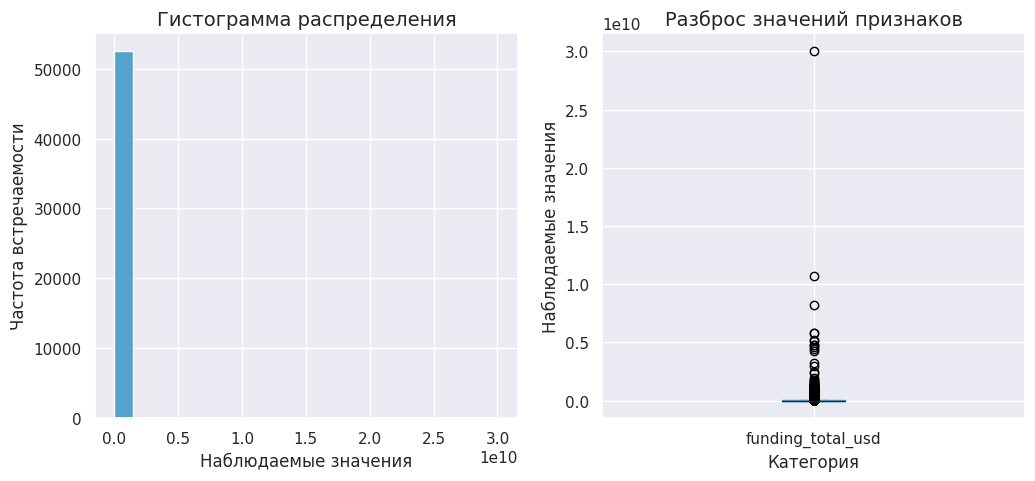

In [66]:
visuals('funding_total_usd')

График нечитаем из-за большого разброса значений данных, логарифмируем столбец для корректного чтения распределения данных и упрощения работы модели в дальнейшем:

In [67]:
#логарифмируем столбец тренировочных данных
startup_train['funding_total_usd'] = np.log(startup_train['funding_total_usd'])

#логарифмируем столбец тестовых данных
startup_test['funding_total_usd'] = np.log(startup_test['funding_total_usd'])

count   52,514.000
mean        14.394
std          2.154
min          0.000
25%         13.179
50%         14.509
75%         15.731
max         24.127
Name: funding_total_usd, dtype: float64

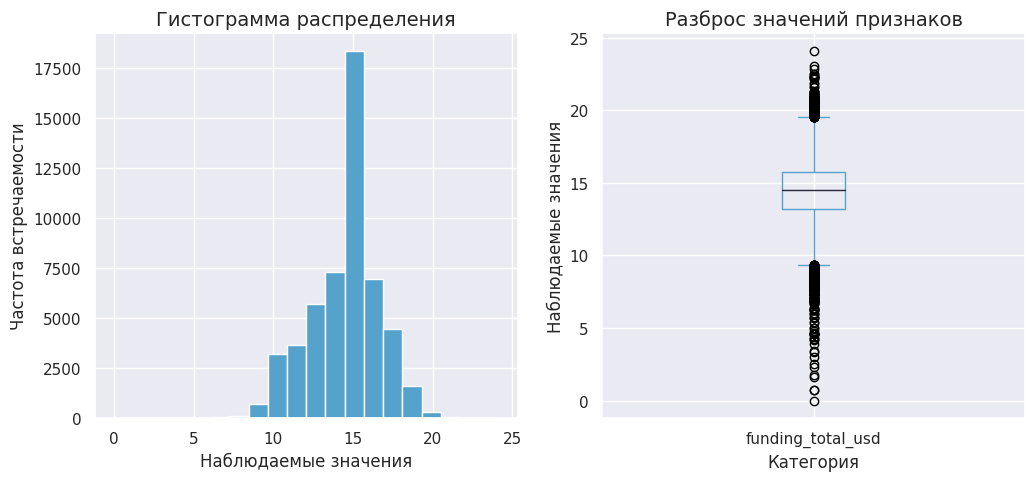

In [68]:
# вызовем повторно функцию визуализации
visuals('funding_total_usd')

In [69]:
# интерпретируем логарифмированные значения в USD для формирования вывода
np.exp(13), np.exp(16)

(442413.3920089205, 8886110.520507872)

**Вывод**

Признак `funding_total_usd` отображает общую сумму финансирования в USD.
    
Признак распределён нормально, большинство значений располагается в промежутке от 442 413 до 8 886 110 USD.

Выбросы и аномалии в данных отсутствуют.

- **Признак `funding_rounds`:**

count   52,514.000
mean         1.741
std          1.375
min          1.000
25%          1.000
50%          1.000
75%          2.000
max         19.000
Name: funding_rounds, dtype: float64

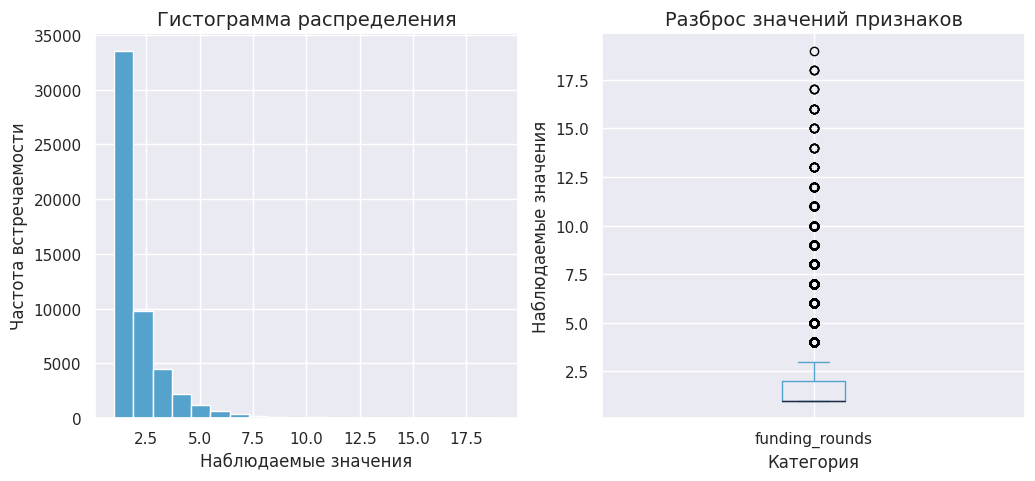

In [70]:
visuals('funding_rounds')

**Вывод:**
    
Признак `funding_rounds` отображает количество раундов финансирования.
    
Распределение признака асимметрично вправо, большинство значений располагается в промежутке от 1 до 2 раундов.

Выбросы и аномалии в данных отсутствуют.

---

### Категориальные признаки

Изучим категориальные признаки датафрейма `startup_train`.

Напишем функцию, которая визуализирует признак с помощью столбчатой гистограммы:

In [71]:
def cat_visuals(cat):
    ax = sns.countplot(x=startup_train[cat],
                   order=startup_train[cat].value_counts(ascending=False).index);

    abs_values = startup_train[cat].value_counts(ascending=False).values

    ax.bar_label(container=ax.containers[0], labels=abs_values)
    ax.set_title('Распределение категорий признака ' + cat)
    ax.set(xlabel='Категории', ylabel='Частота встречаемости')
    ax.figure.set_size_inches(12,6);

- **Признак `status`:**

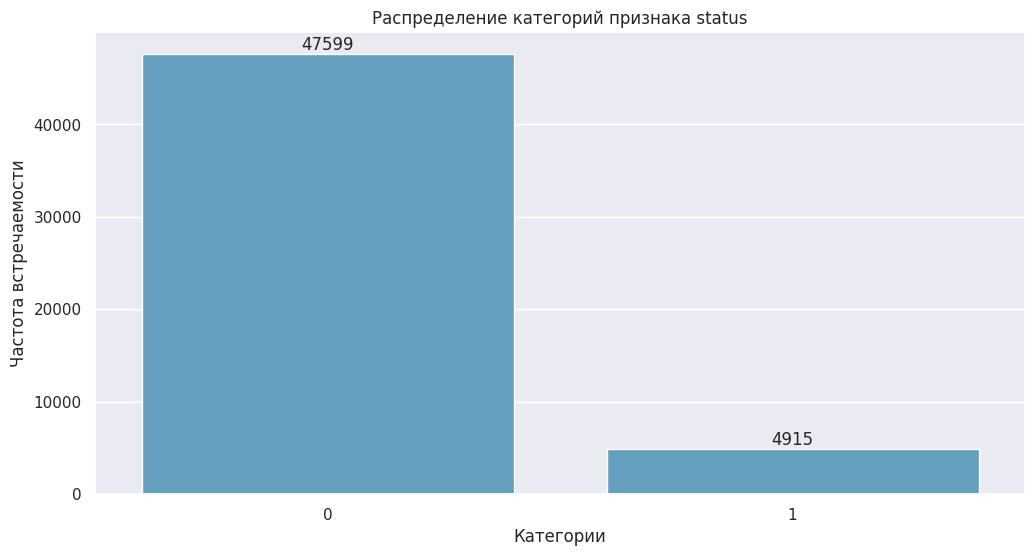

In [72]:
cat_visuals('status')

**Вывод**

Признак `status` представлен категориями:
- 0 «operating»
- 1 «closed»

В выборке преобладает статус «operating».  Целевой признак не сбалансирован, учтём это при формировании обучающей выборки для модели.

---
- **Местоположение стартапа**

Рассмотрим 10 самых часто встречающихся стран расположения стартапов.

In [73]:
#функция для визуализации 10 самых часто встречающихся значений без учёта категории-заглушки
def cat_visuals_top(cat):
    filtered_data = startup_train[startup_train[cat] != 'Unknown']

    ax = sns.countplot(x=filtered_data[cat],
                   order=filtered_data[cat].value_counts(ascending=False).head(10).index);

    abs_values = filtered_data[cat].value_counts(ascending=False).head(10).values

    ax.bar_label(container=ax.containers[0], labels=abs_values)
    ax.set_title('Распределение категорий признака ' + cat)
    ax.set(xlabel='Категории', ylabel='Частота встречаемости')
    ax.figure.set_size_inches(20,10);


- **Признак `country_code`**

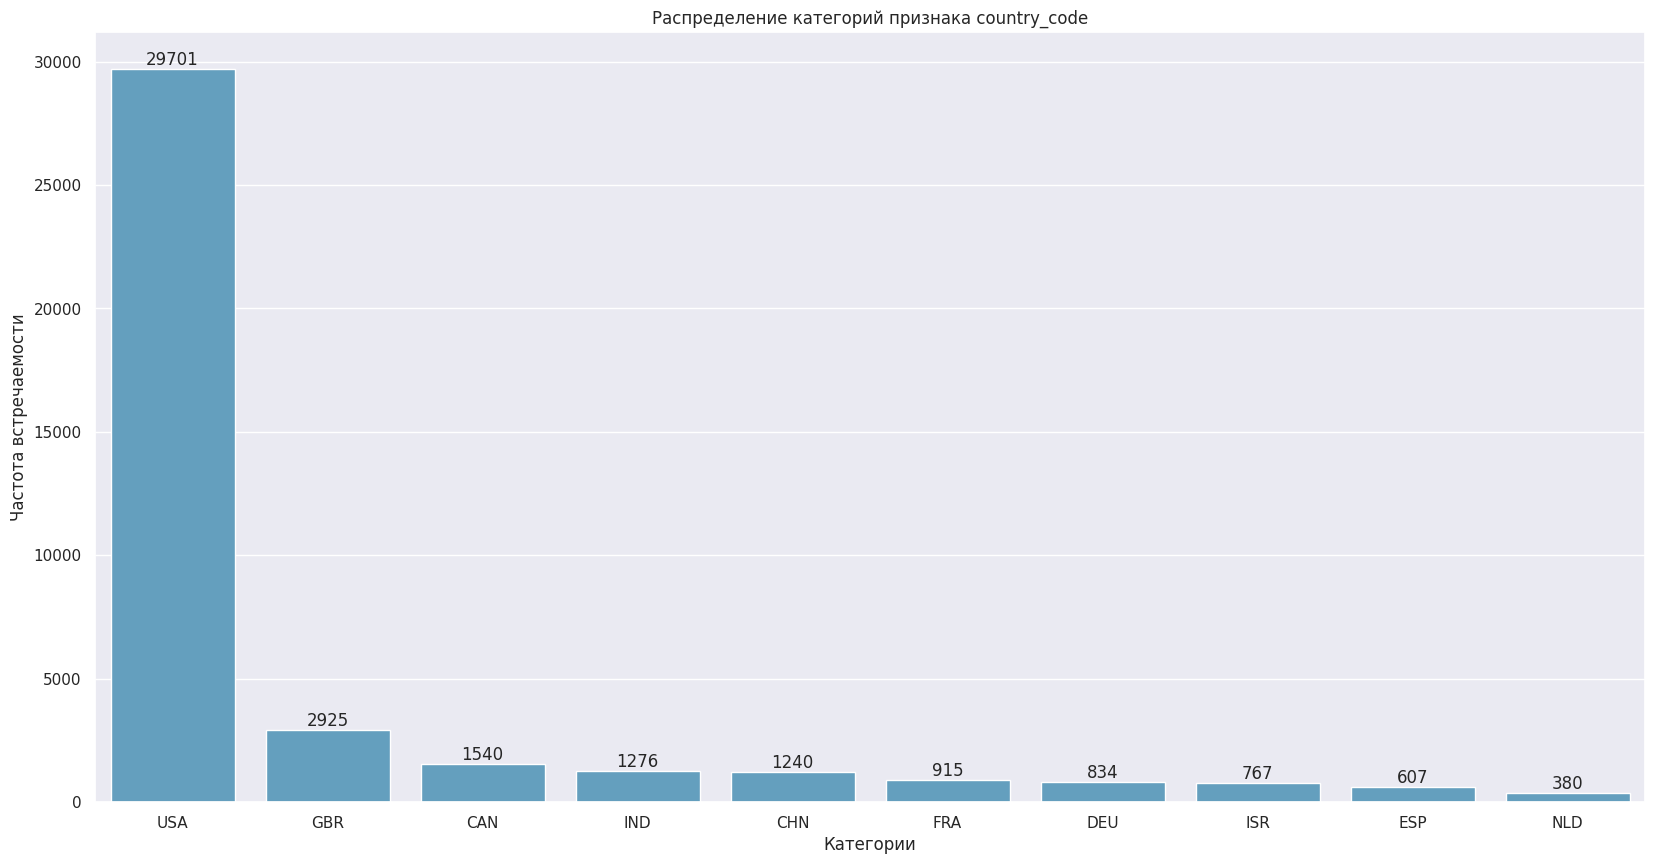

In [74]:
cat_visuals_top('country_code')

**Вывод**

Наиболее распростарнённая страна расположения стартапа - США.

В топ-5 также вошли следующие страны:
- Великобритания;
- Канада;
- Индия;
- Китай.

В данных странах зарегистрировано более 1000 стартапов по данным исследуемой выборки.


- **Признак `region`**

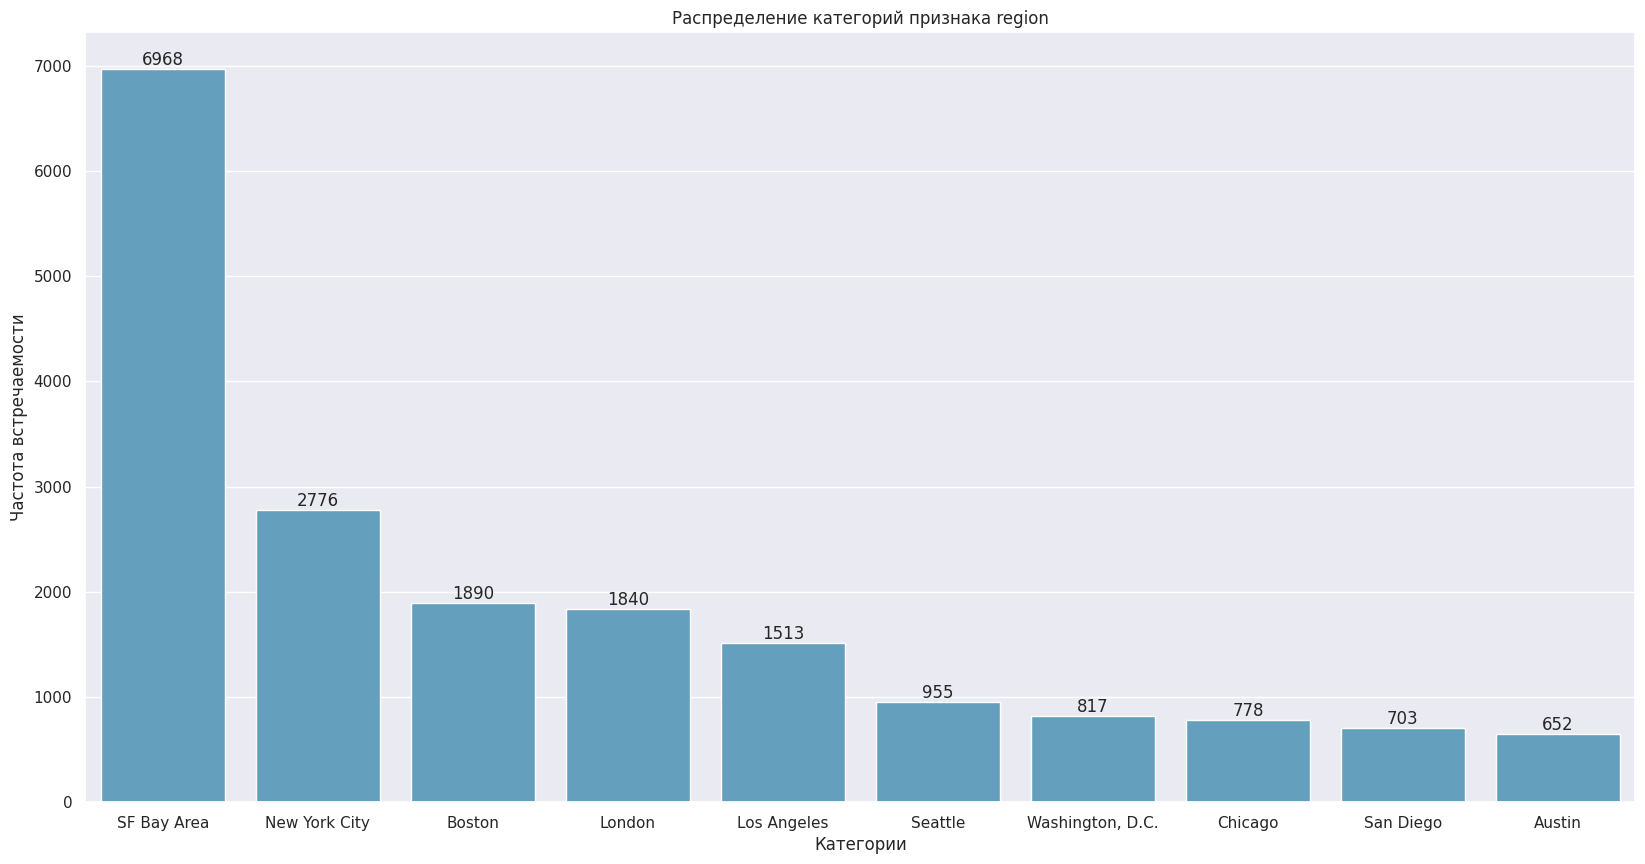

In [75]:
cat_visuals_top('region')

**Вывод**

Самый частый регион расположения стартапа - область залива Сан-Франциско, США.

В список лидеров также вошли следующие регионы:
- Нью-Йорк, США;
- Бостон, США;
- Лондон, Великобритания;
- Лос-Анджелес, США.

В данных регионах зарегистрировано более 1000 стартапов по данным исследуемой выборки.

- **Признак `city`**

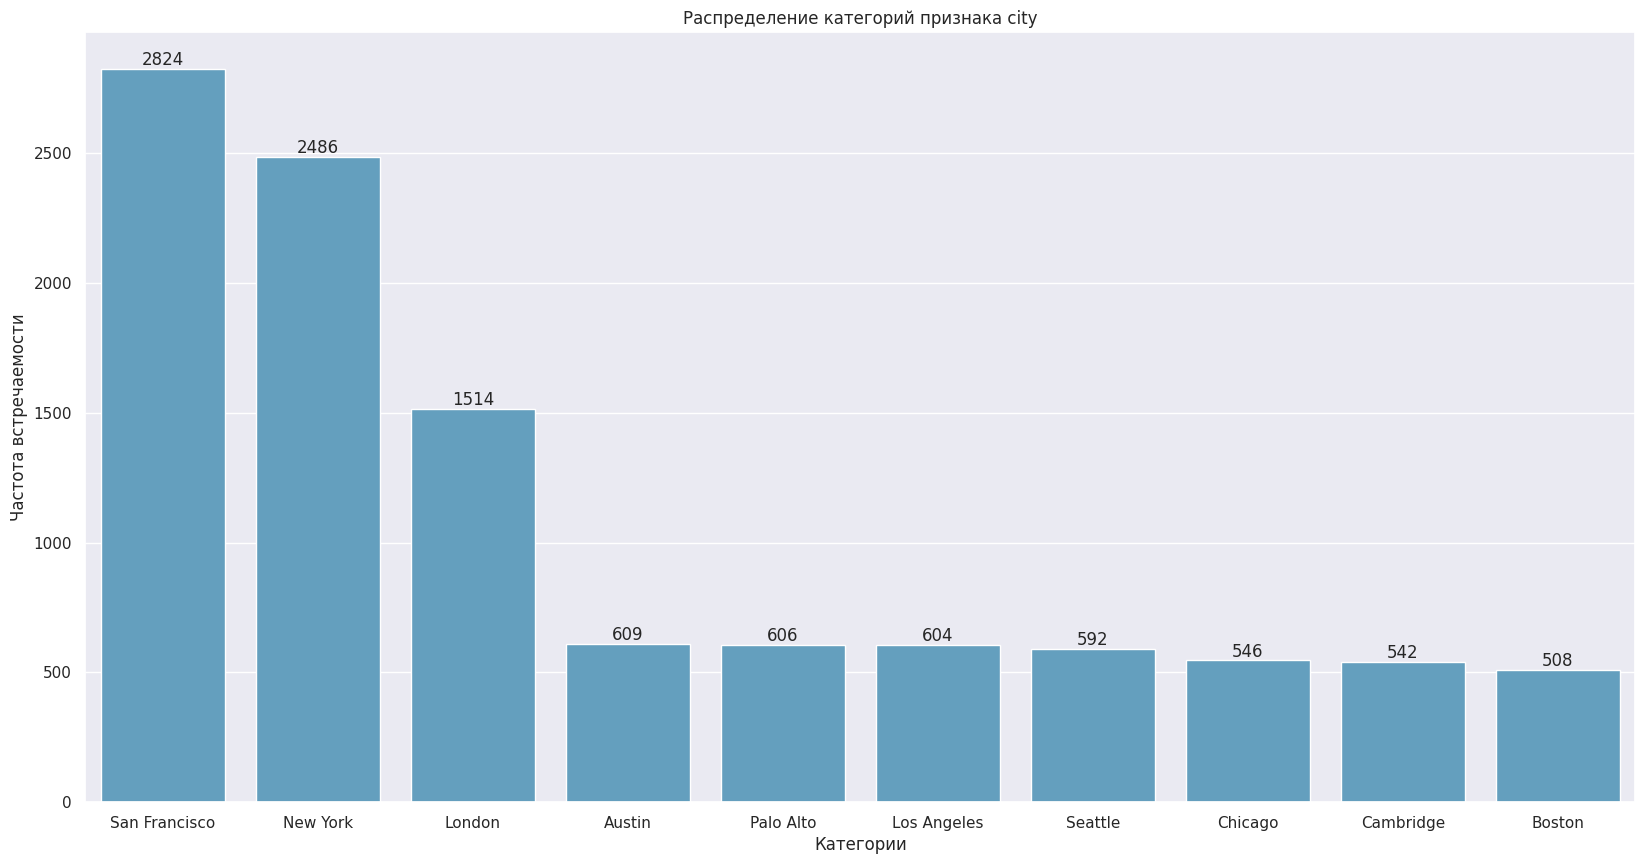

In [76]:
cat_visuals_top('city')

**Вывод**

Самый частый город расположения стартапа - Сан-Франциско.

В список лидеров также вошли следующие города:
- Нью-Йорк;
- Лондон.

В данных городах зарегистрировано более 1000 стартапов по данным исследуемой выборки.

---

- **Категория стартапа**

Выберем 10 самых популярных категорий деятельности стартапа без учёта значения-заглушки `Unknown` и построим визуализацию с помощью столбчатой гистограммы.

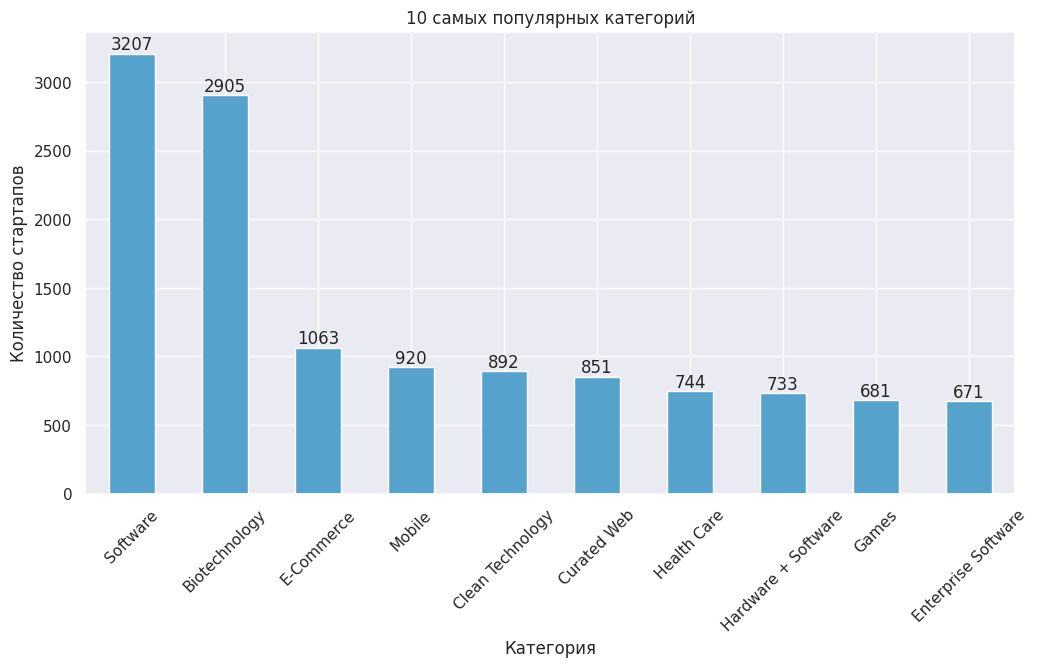

In [77]:
# Выберем 10 самых популярных категорий
top_categories = (
    startup_train[
        (startup_train["category_list"] != "Unknown")
        & (startup_train["category_list"].apply(lambda row: "|" not in str(row)))
    ]["category_list"]
    .value_counts()
    .loc[lambda x: x >= 10]
    .nlargest(10)
)

# Визуализируем выбранные категории столбчатой гистограммой
plt.figure(figsize=(12, 6))
top_categories.plot(kind='bar')
plt.title('10 самых популярных категорий')
plt.xlabel('Категория')
plt.ylabel('Количество стартапов')
plt.xticks(rotation=45)

# Добавляем количество стартапов над каждым столбцом
for i, v in enumerate(top_categories):
    plt.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

**Вывод:**

Наиболее популярными категориями деятельности стартапов являются:

- Software;
- Biotechnology;
- E-Commerce;
- Mobile;
- Clean Technology;
- Curated Web;
- Health Care;
- Hardware + Software;
- Games;
- Enterprise Software

Категории `Software` и `Biotechnology` лидируют в популярности со значительным отрывом.

---

### Временные признаки

Изучим временные признаки датафрейма `startup_train`.

Напишем функцию, которая визуализирует признак с помощью функции `displot()`:

In [78]:
# функция для визуализации частоты встречаемости дат по годам
def date_visuals(cat):
    ax = sns.displot(startup_train[cat].dt.year).set(title='Распределение значений признака ' + cat + ' по годам')

    ax.set(xlabel='Год', ylabel='Частота встречаемости')
    ax.figure.set_size_inches(12,6);

- **Признак `founded_at`:**

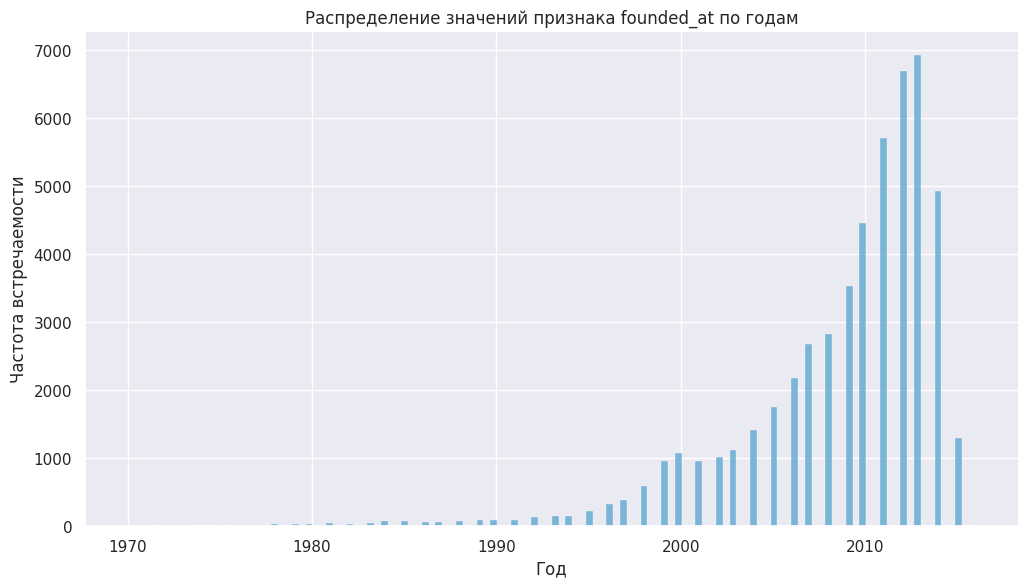

In [79]:
date_visuals('founded_at')

**Вывод**

Признак `founded_at` отображает дату основания стартапа.

Визуализация показывает заметный рост количества открытых стартапов к 2000 году, пик которого пришёлся на 2015 год.

- **Признак `first_funding_at`:**

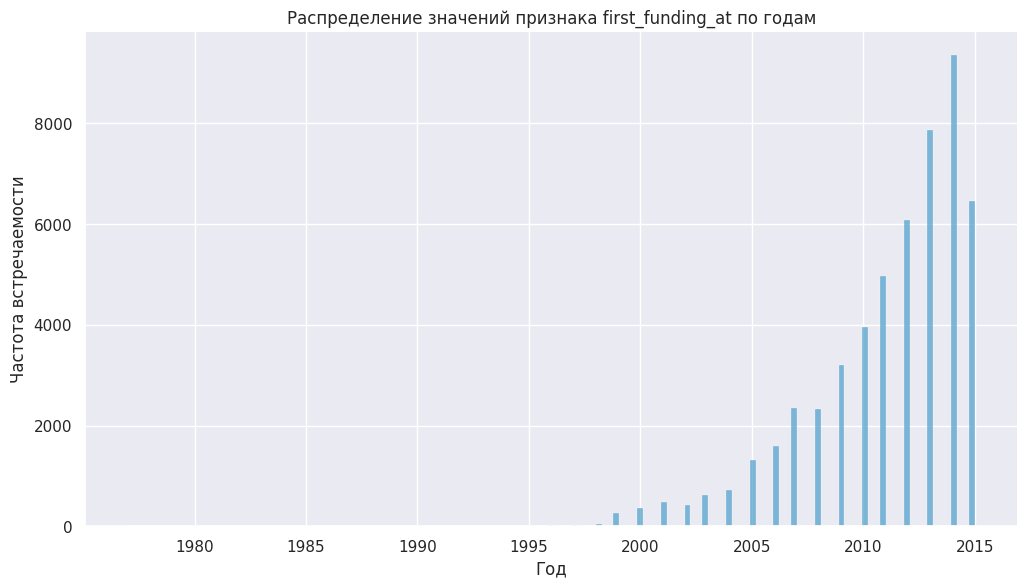

In [80]:
date_visuals('first_funding_at')

**Вывод**

Признак `first_funding_at` отображает дату первого раунда финансирования стартапа.

Рост начала финансирования стартапов отмечается к 2000 году и достигает своего пика в 2014 году, что совпадает с динамикой роста открытия стартапов.

- **Признак `first_funding_at`:**

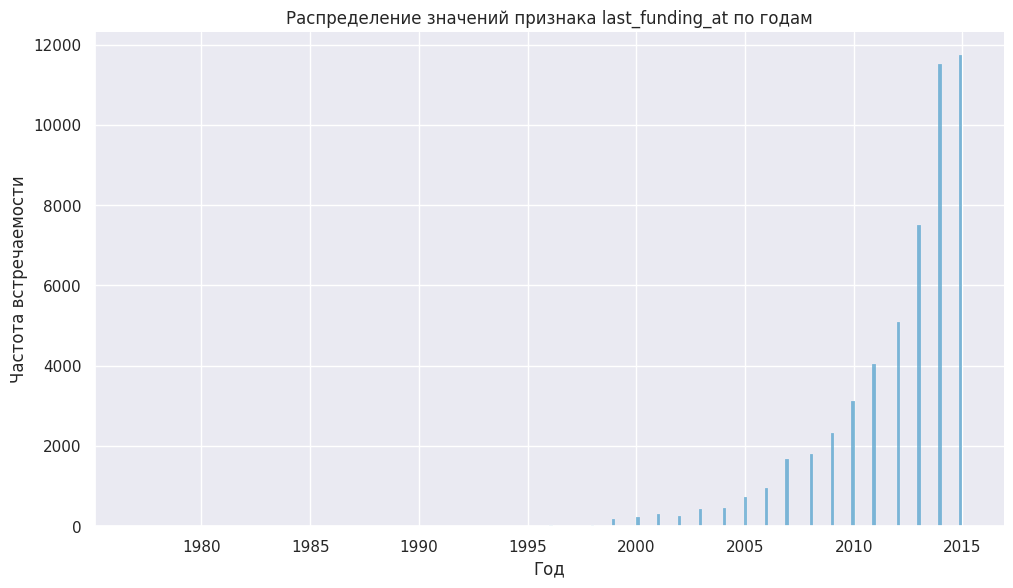

In [81]:
date_visuals('last_funding_at')

**Вывод**

Признак `last_funding_at` отображает дату последнего раунда финансирования стартапа.

Визуализация отмечает постепенный рост завершающих раундов финансирования с 2000 по 2015 годы с большим скачком в 2014 году.

- **Признак `closed_at`:**

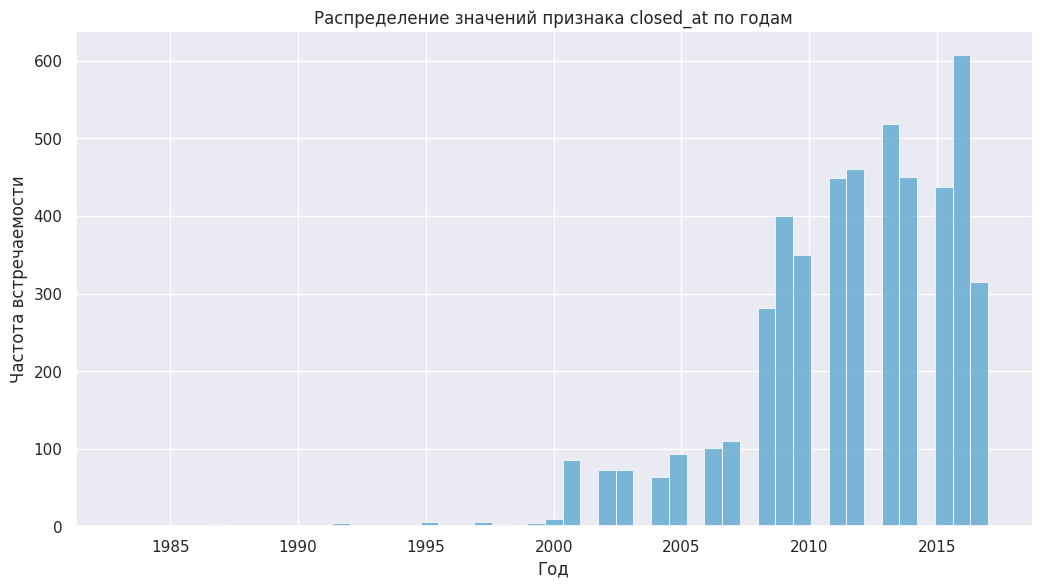

In [82]:
date_visuals('closed_at')

**Вывод**

Признак `closed_at` отображает дату закрытия стартапа.

На визуализации можно отметить резкий скачок количества закрытых стартапов в 2008 году с последующим увеличением до максимального числа закрытых стартапов в 2017 году.

Резкий рост числа закрытых стартапов в 2008 году может быть связан с Мировым экономическим кризисом.

---
**Вывод раздела:**

В датафрейме `startup_train` 2 количественных, 3 категориальных и 4 временных признака.
    
Выбросов и аномалий в данных не обнаружено.

---

## Добавление признаков

В целях проведения исследования добавим дополнительные столбцы в датафреймы с тренировочными и тестовыми данными.

---
-  **Срок деятельности стартапа**

- Столбец `lifetime`

Добавим в датафрейм `startup_train` столбец `lifetime`, содержащий срок существования стартапа в днях.

В первую очередь рассчитаем срок жизни закрытых стартапов, для которых указана дата закрытия в столбце `closed_at`.

In [83]:
# Считаем срок деятельности закрытых стартапов в днях
startup_train["lifetime"] = (
    startup_train["closed_at"] - startup_train["founded_at"]
).dt.days

# Проверяем результат:
startup_train['lifetime'].sample(5)

38436   733.000
52347       NaN
39503   583.000
45383       NaN
22521       NaN
Name: lifetime, dtype: float64

Добавим срок существования для действующих стартапов с помощью даты создания стартапа и даты формирования выгрузки.

Дата формирования выгрузки - `2018-01-01`.

In [84]:
# Считаем срок деятельности открытых стартапов в днях
days_lifetime = datetime(2018, 1, 1) - startup_train['founded_at']

startup_train["lifetime"] = (
    startup_train["lifetime"].fillna(days_lifetime.dt.days).astype(int)
)

#Проверяем результат:
print('Количество пропущенных значений в столбце:', (startup_train['lifetime'].isna().sum()))
startup_train['lifetime'].sample(5)

Количество пропущенных значений в столбце: 0


32498    1354
47693    1979
7093     2057
18686    1862
7538     2930
Name: lifetime, dtype: int64

- Столбец  `founded_at_year`

Вынесем год основания стартапа в отдельный столбец `founded_at_year`.

In [85]:
# Добавим столбец с годом основания стартапа в тренировочный датафрейм
startup_train["founded_at_year"] = startup_train["founded_at"].dt.to_period("Y")

# Добавим столбец с годом основания стартапа в тестовый датафрейм
startup_test["founded_at_year"] = startup_test["founded_at"].dt.to_period("Y")

#Проверим результат
display(startup_train['founded_at_year'].sample(5))
startup_test['founded_at_year'].sample(5)

12403    2005
36045    2011
16390    2013
26636    2012
16425    2010
Name: founded_at_year, dtype: period[A-DEC]

7129    2011
2107    2004
2483    2013
8485    2009
2965    2012
Name: founded_at_year, dtype: period[A-DEC]

---
-  **Финансирование стартапа**

- Признак `lifetime_before_funding`

Добавим столбец `lifetime_before_funding`, содержащий срок существования стартапа до первого раунда финансирования.

Период жизни стартапа на собственные средства укажем в днях.

In [86]:
#добавляем столбец в тренировочный датафрейм
startup_train["lifetime_before_funding"] = (
    startup_train["first_funding_at"] - startup_train["founded_at"]
).dt.days.astype(int)

#добавляем столбец в тестовый датафрейм
startup_test["lifetime_before_funding"] = (
    startup_test["first_funding_at"] - startup_test["founded_at"]
).dt.days.astype(int)

#проверяем результат
display(startup_train.sort_values(by='lifetime_before_funding').head(5))
startup_test.sort_values(by='lifetime_before_funding').head(5)

,name,category_list,funding_total_usd,status,country_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,founded_at_year,lifetime_before_funding
26623,myTwins,Unknown,14.509,0,ISR,NaN,NaN,1,2011-12-01,1986-01-01,1986-01-01,NaT,2223,2011,-9465
52195,WebTV,Games|Internet|Photography|Social Media|Video|...,14.509,0,Unknown,NaN,NaN,1,2012-10-16,1998-01-01,1998-01-01,NaT,1903,2012,-5402
30934,UTStarcom,Curated Web|Internet,19.011,0,CHN,Beijing,Beijing,5,2010-09-01,1996-12-01,2010-02-01,NaT,2679,2010,-5022
51216,NetSanity,SaaS,14.509,0,USA,Charlotte,Charlotte,2,2013-04-01,1999-12-19,2014-07-10,NaT,1736,2013,-4852
14333,ActionBase,Advertising|Business Development,12.899,0,ISR,Tel Aviv,Tel Aviv,1,2007-03-01,1994-07-09,1994-07-09,NaT,3959,2007,-4618


,name,category_list,funding_total_usd,country_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime,founded_at_year,lifetime_before_funding
10418,Questia Media,Education,18.315,USA,Houston,Houston,1,2010-09-01,2000-08-23,2000-08-23,2679,2010,-3661
3243,ClearTracks,Cloud-Based Music|Music|Music Services,14.509,USA,New York City,New York,1,2015-01-01,2005-11-15,2005-11-15,1096,2015,-3334
11917,"TurnHere, Inc.",Curated Web|Digital Media|Distribution|Film|Video,16.279,USA,SF Bay Area,Emeryville,4,2015-07-15,2006-11-01,2012-06-01,901,2015,-3178
7416,eBusinessCards.com,Printing|Small and Medium Businesses,9.616,USA,SF Bay Area,San Francisco,1,2014-01-01,2006-03-08,2006-03-08,1461,2014,-2856
13039,Tellpe,Mobile,14.122,FRA,SÃ¨te,Sète,1,2011-11-18,2005-01-01,2005-01-01,2236,2011,-2512


In [87]:
startup_test.sort_values(by='lifetime_before_funding')['lifetime_before_funding'].head(5)

10418   -3661
3243    -3334
11917   -3178
7416    -2856
13039   -2512
Name: lifetime_before_funding, dtype: int64

Выявлены стартапы, в которых финансирование началось ещё до даты основания компании.

Удалим данные компании из тренировочной выгрузки, чтобы не обучать модель на некорректных данных:





In [88]:
print("Размер тренировочного датафрейма до удаления строк", (startup_train.shape))
print(
    "Количество строк тренировочного датафрейма с некорректными датами начала финансирования",
    (startup_train[startup_train["lifetime_before_funding"] < 0].shape[0]),
)

Размер тренировочного датафрейма до удаления строк (52514, 15)
Количество строк тренировочного датафрейма с некорректными датами начала финансирования 2933


In [89]:
# удаляем строки с некорректными данными в тренировочном датафрейме
startup_train = startup_train[startup_train["lifetime_before_funding"] >= 0]

# проверяем результат
print("Размер датафрейма после удаления строк", (startup_train.shape))

Размер датафрейма после удаления строк (49581, 15)


- Признак `first_funding_year`

Вынесем год первого финансирования стартапа в отдельный столбец.

In [90]:
# Добавим столбец в тренировочный датафрейм
startup_train["first_funding_year"] = startup_train.loc[:, "first_funding_at"].dt.year

# Добавим столбец в тестовый датафрейм
startup_test["first_funding_year"] = startup_test.loc[:, "first_funding_at"].dt.year

#Проверим результат
display(startup_train['first_funding_year'].sample(5))
startup_test['first_funding_year'].sample(5)

25979    2015
1442     2014
35816    2012
40478    2014
19018    2012
Name: first_funding_year, dtype: int32

6153     2009
7618     2008
11649    2014
4116     2008
3336     2015
Name: first_funding_year, dtype: int32

- Признак `last_funding_year`

Вынесем также год последнего финансирования стартапа в отдельный столбец.

In [91]:
# Добавим столбец в тренировочный датафрейм
startup_train['last_funding_year'] = startup_train.loc[:, 'last_funding_at'].dt.year

# Добавим столбец в тестовый датафрейм
startup_test['last_funding_year'] = startup_test.loc[:, 'last_funding_at'].dt.year

#Проверим результат
display(startup_train['last_funding_year'].sample(5))
startup_test['last_funding_year'].sample(5)

44792    2012
36899    2004
43814    2013
20097    2012
49911    2011
Name: last_funding_year, dtype: int32

12195    2010
2337     2015
6150     2014
1685     2012
8510     2007
Name: last_funding_year, dtype: int32

- Признак `time_between_funding`

Добавим столбец со сроком полного цикла финансирования стартапа: сколько дней прошло между первым и последним раундом финансирования.

In [92]:
# Добавим столбец в тренировочный датафрейм
startup_train["time_between_funding"] = (
    startup_train["last_funding_at"] - startup_train["first_funding_at"]
).dt.days.astype(int)

# Добавим столбец в тестовый датафрейм
startup_test["time_between_funding"] = (
    startup_test["last_funding_at"] - startup_test["first_funding_at"]
).dt.days.astype(int)

#Проверим результат
display(startup_train['time_between_funding'].sample(5))
startup_test['time_between_funding'].sample(5)

29220      0
14985    231
20778      0
43728      0
18698    335
Name: time_between_funding, dtype: int64

2743      578
12350     426
10463    1520
9754        0
8298        0
Name: time_between_funding, dtype: int64

---

**Вывод раздела:**

Добавление дополнительных столбцов помогло уменьшить кардинальность некоторых признаков, найти некорректные данные в выборке, а также будет использовано для поиска закономерностей в дальнейшем исследовании.

---

## Корреляционный анализ

Проведём корреляционный анализ признаков датафрейма `startup_train`.

Признак `status` - целевой, изучим взаимосвязь входных признаков с целевым, а также проверим выборку на наличие мультиколлинеарности признакового описания.

#### Матрица корреляции

Корреляцию признаков рассмотрим с помощью матрицы корреляций `phik_matrix()`.

In [93]:
# функция построения матрицы корреляции
def phik_matrix(columns, size):
    # список интервальных признаков
    interval_cols = columns.select_dtypes(include='number').columns.tolist()

    # вычисление коэффициентов корреляции phi для датафрейма
    phik_overview = columns.phik_matrix(interval_cols=interval_cols)

    # визуализация тепловой карты коэффициентов корреляции
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        title=r"Матрица корреляции $\phi_K$",
        fontsize_factor=1.5,
        figsize=size
    )

Построим матрицу корреляции с использованием дополнительно добавленных столбцов:

- признак `category_list` исследуем с помощью сэмпла полученной ранее матрицы категорий;

- признак `funding_total_usd` исследуем в изначальном виде;

- целевой признак `status` - в изначальном виде;

-  признаки `country_code`,	`region` и `city` изучим в изначальном виде;

- признак `funding_rounds` - в изначальном виде;

- признак `founded_at` исследуем с помощью столбца  `founded_at_year`;

-  признаки `first_funding_at` и `last_funding_at` исследуем с помощью столбцов  `first_funding_year` и `last_funding_year`;

- признак `closed_at` изучим через столбец `lifetime`;

Дополнительно исследуем добавленные признаки `lifetime_before_funding` и `time_between_funding`.

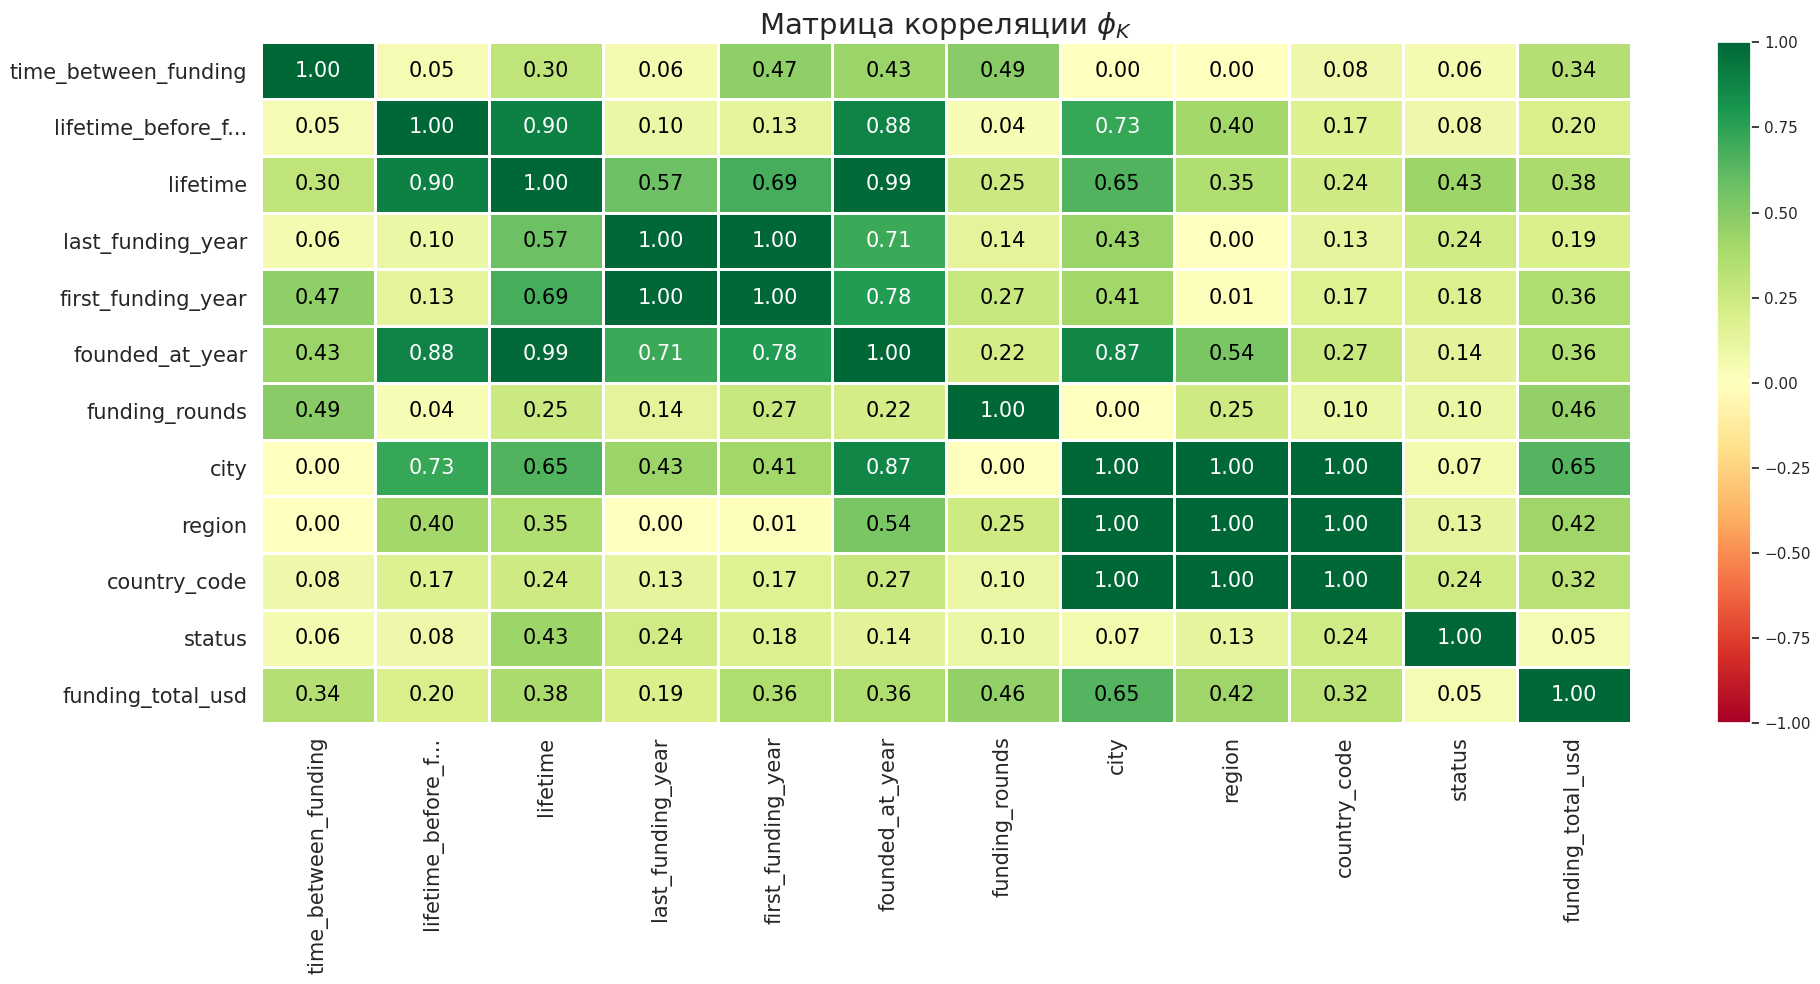

In [94]:
# вызовем функцию матрицы phik и передадим выбранные столбцы
phik_matrix(
    startup_train.loc[
        :,
        [
            "funding_total_usd",
            "status",
            "country_code",
            "region",
            "city",
            "funding_rounds",
            "founded_at_year",
            "first_funding_year",
            "last_funding_year",
            "lifetime",
            "lifetime_before_funding",
            "time_between_funding",
        ],
    ],
    (20, 10),
)

**Вывод:**

Умеренная зависимость с целевым признаком `status` выявлена у признака `lifetime`, у остальных входных признаков слабая зависимость с целевым.

Выявлена мультиколлинеарность входных признаков:

- Признак `lifetime` с признаками:
  - `lifetime_before_funding`
  -  `founded_at_year`

Оставим в выборке признак `lifetime`.

- Между признаками `last_funding_year` и `first_funding_year`

Оставим в выборке признак `last_funding_year`.

- Признак `country_code` с признаками:
 - `region`
 - `city`

Из столбцов-индикаторов местоположения стартапа оставим в выборке признак `country_code`.

Построим матрицу корреляции по отобранным столбцам:

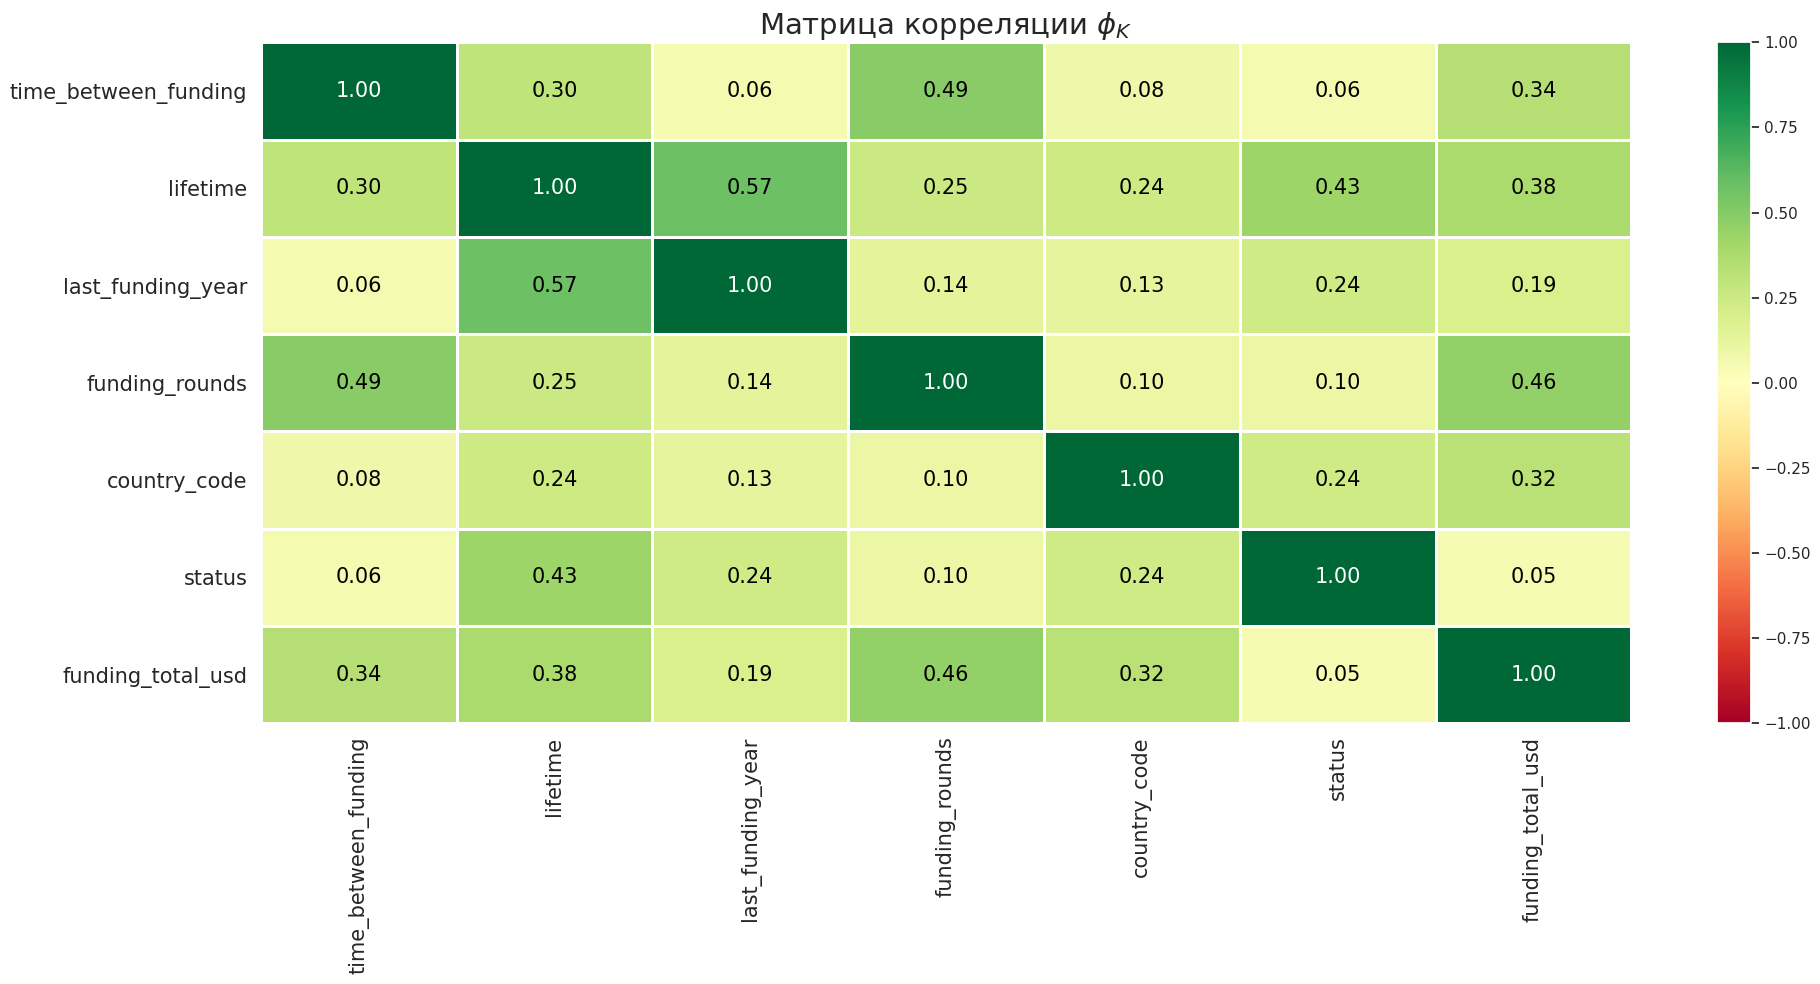

In [95]:
phik_matrix(
    startup_train.loc[
        :,
        [
            "funding_total_usd",
            "status",
            "country_code",
            "funding_rounds",
            "last_funding_year",
            "lifetime",
            "time_between_funding",
        ],
    ],
    (20, 10),
)

Мультиколлинеарность входных признаков устранена.

Используем полученный список признаков для обучения модели, для чего удалим остальные признаки из датафреймов:

In [96]:
# удалим признаки из тренировочного датафрейма
startup_train = startup_train.loc[
    :,
    [
        "name",
        "category_list",
        "funding_total_usd",
        "status",
        "country_code",
        "funding_rounds",
        "last_funding_year",
        "lifetime",
        "time_between_funding",
    ],
]

In [97]:
# проверим результат
startup_train.head()

,name,category_list,funding_total_usd,status,country_code,funding_rounds,last_funding_year,lifetime,time_between_funding
0,Lunchgate,Online Reservations|Restaurants,13.628,0,CHE,2,2014,2923,1310
1,EarLens,Manufacturing|Medical|Medical Devices,17.575,0,USA,4,2014,4748,1393
2,Reviva Pharmaceuticals,Biotechnology,17.384,0,USA,3,2014,4383,681
3,Sancilio and Company,Health Care,16.918,0,Unknown,3,2014,5114,1051
4,WireTough Cylinders,Manufacturing,14.509,0,USA,1,2012,2650,0


В тренировочном датафрейме остались признаки, отобранные для обучения модели.

In [98]:
# удалим признаки из тестового датафрейма
startup_test = startup_test.loc[
    :,
    [
       "name",
       "category_list",
        "funding_total_usd",
        "country_code",
        "funding_rounds",
        "last_funding_year",
        "lifetime",
        "time_between_funding",
    ],
]

In [99]:
# проверим результат
startup_test.head()

,name,category_list,funding_total_usd,country_code,funding_rounds,last_funding_year,lifetime,time_between_funding
0,Crystalsol,Clean Technology,14.852,NIC,1,2009,3501,0
1,JBI Fish & Wings,Hospitality,14.509,USA,1,2010,2717,0
2,COINPLUS,Finance,12.967,LUX,2,2014,1295,126
3,Imagine Communications,Software|Video|Video Streaming,17.362,USA,4,2010,4748,1935
4,DNA13,Software,15.326,CAN,1,2007,6209,0


Признаки удалены.

#### Целевой признак

Дополнительно изучим сопряжённость целевого признака `status` и входных признаков датафрейма.

- **Количественные признаки**

Напишем функцию `target_num()` для отображения распределения количественных признаков датафрейма в разрезе целевого признака `status`.

In [100]:
def target_num(col):
    fig, axes = plt.subplots(figsize=(12,6))

    sns.violinplot(data=startup_train, x='status', y=col, ax=axes)

    plt.title("Распределение признака " + col + " в разрезе статуса стартапа")
    plt.xlabel("статус стартапа")
    plt.ylabel("признак " + col);

- Признак `funding_total_usd`

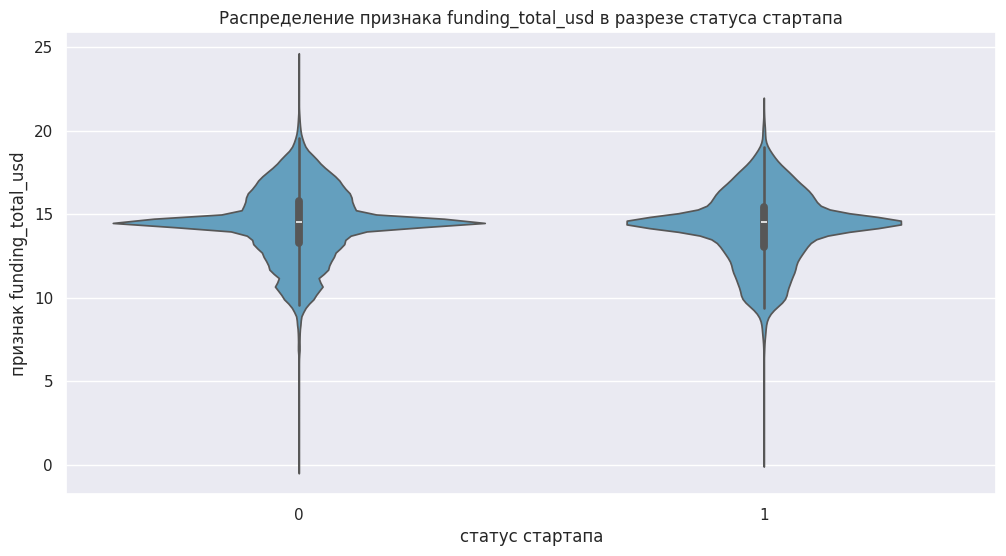

In [101]:
target_num('funding_total_usd')

In [102]:
np.exp(14)

1202604.2841647768

**Вывод:**

Сумма финансирования действующих и закрытых компаний однородна: наиболее часто встречаемое значение в 1 202 604 USD соответствует обоим статусам стартапов.

- Признак `funding_rounds`

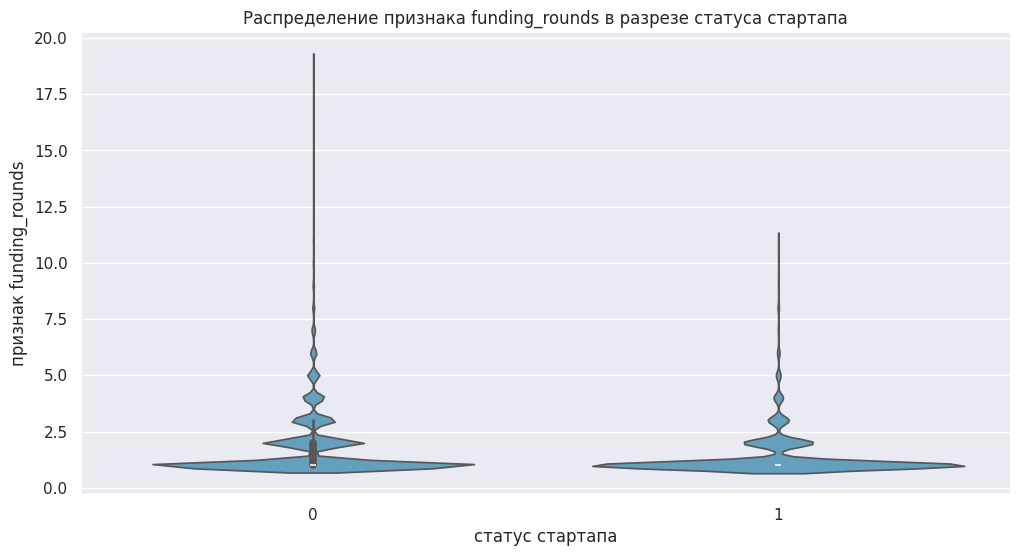

In [103]:
target_num('funding_rounds')

**Вывод:**

Можно отметить, что наиболее часто встречающееся количество раундов финансирования совпадает для обоих статусов стартапов - 1 раунд.

При этом, действующие стартапы получают больше раундов финансирования.

- Признак `lifetime`

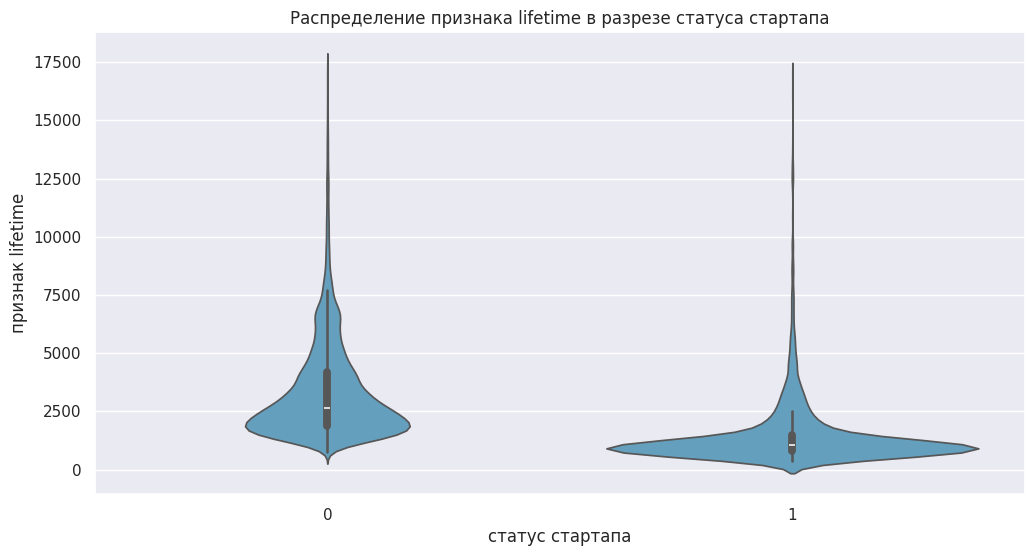

In [104]:
target_num('lifetime')

**Вывод:**

Действующим стартапам соответствует бóльший срок жизни: в среднем 7-9 лет.

Продолжительность деятельности закрытых стартапов - 3-4 года.



---

**Вывод раздела:**

Проведён корреляционный анализ датафрейма `startup_train` и графическое исследование сопряжённости целевого признака `status` и входных признаков.

Умеренная зависимость с целевым выявлена признака `lifetime`.

Мультиколлинеарность входных признаков отсутствует.

### Обучение моделей

Выберем лучшую модель для прогноза успешности стартапа.

Для решения задачи обучим две модели:

- `RandomForestClassifier()`;
- `CatBoostClassifier()`.

Каждую из моделей обучим на данных тренировочной выборки и с использованием матрицы признаков деятельности стартапов.

Выбор модели для прогноза сделаем на основе метрики `F1-Score`.

---

#### Модель `RandomForestClassifier()`

Напишем пайплайн для модели дерево решений классификации:
    
- для работы с категориальными данными выберем кодировщик `OrdinalEncoder`;
- пропуски в данных заполним константным значением `Unknown`;
- масштабирование количественных данных выполним с помощью `MinMaxScaler()`;
- зададим перебор заданных гиперпараметров методом `OptunaSearchCV`;
- качество модели оценим с помощью метрики `F1-Score`.

##### - `данные тренировочной выборки`

Построим модель `RandomForestClassifier()` и обучим её на данных тренировочной выборки.

In [105]:
# обозначим входные и целевой признаки
X = startup_train.drop(columns=['name', 'status'], axis=1)
y = startup_train['status']

# разделим данные на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    )

# устраним дисбаланс классов целевого признака
# создадим экземпляр RandomOverSampler
ros = RandomOverSampler()

# применим увеличение выборки к тренировочным данным
X_train, y_train = ros.fit_resample(X_train, y_train)

# создадим списки с названиями признаков
ord_columns = X_train.select_dtypes(exclude='number').columns.tolist()
num_columns = X_train.select_dtypes(include='number').columns.tolist()

# создадим пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков + Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')),
     ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-999))
    ]
)

# создадим общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создадим итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestClassifier(n_estimators=10, random_state=RANDOM_STATE))
])

# зададим диапазон гиперпараметров
parameters = {
    'models__max_depth': distributions.IntDistribution(2, 60),
    'models__min_samples_split': distributions.IntDistribution(2, 30)
}

# зададим перебор гиперпараметров с помощью Optuna
oscv_forest = OptunaSearchCV(
    pipe_final,
    parameters,
    scoring='f1',
    cv=5,
    n_trials=100,
    random_state=RANDOM_STATE
)

In [106]:
oscv_forest.fit(X_train, y_train);

[I 2024-05-13 11:16:51,508] A new study created in memory with name: no-name-13ad5e8d-d462-443a-a914-dd34360c4c0a
[I 2024-05-13 11:16:55,199] Trial 0 finished with value: 0.9865881728560909 and parameters: {'models__max_depth': 28, 'models__min_samples_split': 26}. Best is trial 0 with value: 0.9865881728560909.
[I 2024-05-13 11:16:57,716] Trial 1 finished with value: 0.9059430582133837 and parameters: {'models__max_depth': 6, 'models__min_samples_split': 11}. Best is trial 0 with value: 0.9865881728560909.
[I 2024-05-13 11:17:02,580] Trial 2 finished with value: 0.9959845013857109 and parameters: {'models__max_depth': 30, 'models__min_samples_split': 10}. Best is trial 2 with value: 0.9959845013857109.
[I 2024-05-13 11:17:06,796] Trial 3 finished with value: 0.973370956674103 and parameters: {'models__max_depth': 14, 'models__min_samples_split': 6}. Best is trial 2 with value: 0.9959845013857109.
[I 2024-05-13 11:17:09,937] Trial 4 finished with value: 0.9535394913333548 and parameter

In [107]:
print('Лучшие параметры модели:', oscv_forest.best_params_)
print('\n\nЛучшая метрика на кросс-валидационной выборке:')
scores = cross_val_score(oscv_forest.best_estimator_, X_train, y_train, cv=5, scoring='f1')
print(scores.mean(), scores)
print('\n\nЛучшая метрика на валидационной выборке:')
scores_valid = cross_val_score(oscv_forest.best_estimator_, X_valid, y_valid, cv=5, scoring='f1')
print(scores_valid.mean(), scores_valid)

Лучшие параметры модели: {'models__max_depth': 32, 'models__min_samples_split': 3}


Лучшая метрика на кросс-валидационной выборке:
0.997769037611423 [0.99743608 0.9980596  0.99709222 0.9981977  0.9980596 ]


Лучшая метрика на валидационной выборке:
0.8473914138124629 [0.85373134 0.85797101 0.84776119 0.82882883 0.84866469]


**Вывод:**

Написан пайплайн для модели `RandomForestClassifier()` с подбором гиперпараметров, который определил лучшую конфигурацию модели с помощью метрики F1-Score.

Модель обучена на данных тренировочной выборки.

Результат работы модели удовлетворительный:

- Метрика на кросс-валидационной выборке: 0.99;
- Метрика на валидационной выборке: 0.84

---
##### - `+ tfidf features`

Построим модель `RandomForestClassifier()` и обучим её на данных тренировочной выборки с добавлением матрицы признаков деятельности стартапов.

Сначала сформируем расширенную тренировочную выборку:


In [108]:
# проверяем размер таблиц до объединения
print(startup_train.shape)
train_categories_df.shape

(49581, 9)


(52514, 855)

In [109]:
# соединяем таблицы по условию
startup_train_tfidf = startup_train.join(train_categories_df, how='inner')

# проверяем размерность итоговой таблицы
print(startup_train_tfidf.shape)

(49581, 864)


Получим лучшие параметры модели, подобранные с помощью `OptunaSearchCV()` в предыдущем шаге и используем их для обучения второй модели на дополненных тренировочных данных:

In [110]:
best_params = {key.replace('models__', ''): value for key, value in oscv_forest.best_params_.items()}
print(best_params)

{'max_depth': 32, 'min_samples_split': 3}


In [111]:
# обозначим входные и целевой признаки
X = startup_train_tfidf.drop(columns=['name', 'status', 'category_list'], axis=1)
y = startup_train_tfidf['status']

# разделим данные на обучающую и валидационную выборки
X_train_tfidf, X_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    )

# сбалансируем категории целевого признака
# создадим экземпляр RandomOverSampler()
ros = RandomOverSampler()

# применим увеличение выборки к тренировочным данным
X_train_tfidf, y_train_tfidf = ros.fit_resample(X_train_tfidf, y_train_tfidf)

# создадим списки с названиями признаков
ord_columns = X_train_tfidf.select_dtypes(exclude='number').columns.tolist()
num_columns = X_train_tfidf.select_dtypes(include='number').columns.tolist()

# создадим пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков + Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')),
     ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-999))
    ]
)

# создадим общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_tfidf= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', RandomForestClassifier(**best_params, random_state=RANDOM_STATE))
])

In [112]:
pipe_tfidf.fit(X_train_tfidf, y_train_tfidf);

In [113]:
print('Лучшая метрика на кросс-валидационной выборке:')
scores_tfid = cross_val_score(pipe_tfidf, X_train_tfidf, y_train_tfidf, cv=5, scoring='f1')
print(scores_tfid.mean(), scores_tfid)
print('\n\nЛучшая метрика на валидационной выборке:')
scores_tfid_valid = cross_val_score(pipe_tfidf, X_valid_tfidf, y_valid_tfidf, cv=5, scoring='f1')
print(scores_tfid_valid.mean(), scores)

Лучшая метрика на кросс-валидационной выборке:
0.9530846159365044 [0.94401267 0.95634185 0.95781673 0.9498323  0.95741954]


Лучшая метрика на валидационной выборке:
0.6713270787932513 [0.99743608 0.9980596  0.99709222 0.9981977  0.9980596 ]


**Вывод:**

Написан пайплайн для модели `RandomForestClassifier()` с подбором гиперпараметров, который определил лучшую конфигурацию модели с помощью метрики F1-Score.

Модель обучена на данных тренировочной выборки с добавлением матрицы категорий деятельности стартапов.

Результат работы модели удовлетворительный:

- Метрика на кросс-валидационной выборке: 0.95;
- Метрика на валидационной выборке: 0.67

---
#### Модель `CatBoostClassifier()`

Построим модель `CatBoostClassifier`(), качество модели оценим с помощью метрики `F1-Score`.

##### - `данные тренировочной выборки`

Построим модель `CatBoostClassifier()` и обучим её на данных тренировочной выборки.

In [114]:
# обозначим входные и целевой признаки
X = startup_train.drop(columns=['name', 'status'])
y = startup_train['status']

# разделим данные на обучающую и валидационную выборки
X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    )

# устраним дисбаланс классов целевого признака
# создадим экземпляр RandomOverSampler
ros = RandomOverSampler()

# применим увеличение выборки к тренировочным данным
X_train_cat, y_train_cat = ros.fit_resample(X_train_cat, y_train_cat)

# зададим категориальные столбцы
cat_features = ['category_list', 'country_code']

# настроим тренировочную и валидационную выборки
train_dataset = Pool(X_train_cat, y_train_cat, cat_features=cat_features)
eval_dataset = Pool(X_valid_cat, y_valid_cat, cat_features=cat_features)

# создадим модель
model = CatBoostClassifier(
    learning_rate=0.1,
    iterations=1000,
    use_best_model=True,
    eval_metric="TotalF1",
    loss_function="Logloss",
    early_stopping_rounds=20
)

In [115]:
model.fit(train_dataset, eval_set=eval_dataset)

0:	learn: 0.8669534	test: 0.9638607	best: 0.9638607 (0)	total: 133ms	remaining: 2m 12s
1:	learn: 0.8903255	test: 0.9667259	best: 0.9667259 (1)	total: 214ms	remaining: 1m 46s
2:	learn: 0.8964538	test: 0.9427292	best: 0.9667259 (1)	total: 285ms	remaining: 1m 34s
3:	learn: 0.9008099	test: 0.9431053	best: 0.9667259 (1)	total: 374ms	remaining: 1m 33s
4:	learn: 0.9046253	test: 0.9503949	best: 0.9667259 (1)	total: 457ms	remaining: 1m 30s
5:	learn: 0.9150279	test: 0.9625184	best: 0.9667259 (1)	total: 550ms	remaining: 1m 31s
6:	learn: 0.9193129	test: 0.9631525	best: 0.9667259 (1)	total: 635ms	remaining: 1m 30s
7:	learn: 0.9283881	test: 0.9644318	best: 0.9667259 (1)	total: 710ms	remaining: 1m 28s
8:	learn: 0.9317495	test: 0.9637897	best: 0.9667259 (1)	total: 791ms	remaining: 1m 27s
9:	learn: 0.9359463	test: 0.9666384	best: 0.9667259 (1)	total: 862ms	remaining: 1m 25s
10:	learn: 0.9379319	test: 0.9669459	best: 0.9669459 (10)	total: 927ms	remaining: 1m 23s
11:	learn: 0.9392845	test: 0.9680705	best

In [116]:
cv_data = eval_dataset
cv_scores_cat = cv(
    cv_data,
    model.get_params(),
    fold_count=10,
    plot=True,
    shuffle=True,
    logging_level="Silent",
)

print("CV score: {:.5f}".format(cv_scores_cat["test-TotalF1-mean"].values[-1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CV score: 0.97588


**Вывод:**

Построена модель `CatBoostClassifier()` с оценкой качества метрикой `F1-Score`.

Модель обучена на данных тренировочной выборки.

Результат работы модели удовлетворительный:

- Метрика на кросс-валидационной выборке: 0.97;
- Метрика на валидационной выборке: 0.97588

---
##### - `+ tfidf features`

Построим модель `CatBoostClassifier()` и обучим её на данных тренировочной выборки с добавлением матрицы признаков деятельности стартапов.

In [117]:
# обозначим входные и целевой признаки
X = startup_train_tfidf.drop(columns=['name', 'status', 'category_list'], axis=1)
y = startup_train_tfidf['status']

# разделим данные на обучающую и валидационную выборки
X_train_cat_tfidf, X_valid_cat_tfidf, y_train_cat_tfidf, y_valid_cat_tfidf = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    )

# устраним дисбаланс классов целевого признака
# создадим экземпляр RandomOverSampler
ros = RandomOverSampler()

# применим увеличение выборки к тренировочным данным
X_train_cat_tfidf, y_train_cat_tfidf = ros.fit_resample(X_train_cat_tfidf, y_train_cat_tfidf)

# зададим категориальные столбцы
cat_features_tfidf = [ 'country_code']

# настроим тренировочную и валидационную выборки
train_dataset_tfidf = Pool(X_train_cat_tfidf, y_train_cat_tfidf, cat_features=cat_features_tfidf)
eval_dataset_tfidf = Pool(X_valid_cat_tfidf, y_valid_cat_tfidf, cat_features=cat_features_tfidf)

# создадим модель
model_tfidf = CatBoostClassifier(
    learning_rate=0.1,
    iterations=1000,
    use_best_model=True,
    eval_metric="TotalF1",
    loss_function="Logloss",
    early_stopping_rounds=20
)

In [118]:
model_tfidf.fit(train_dataset, eval_set=eval_dataset)

0:	learn: 0.8669534	test: 0.9638607	best: 0.9638607 (0)	total: 76.2ms	remaining: 1m 16s
1:	learn: 0.8903255	test: 0.9667259	best: 0.9667259 (1)	total: 145ms	remaining: 1m 12s
2:	learn: 0.8964538	test: 0.9427292	best: 0.9667259 (1)	total: 215ms	remaining: 1m 11s
3:	learn: 0.9008099	test: 0.9431053	best: 0.9667259 (1)	total: 296ms	remaining: 1m 13s
4:	learn: 0.9046253	test: 0.9503949	best: 0.9667259 (1)	total: 369ms	remaining: 1m 13s
5:	learn: 0.9150279	test: 0.9625184	best: 0.9667259 (1)	total: 437ms	remaining: 1m 12s
6:	learn: 0.9193129	test: 0.9631525	best: 0.9667259 (1)	total: 514ms	remaining: 1m 12s
7:	learn: 0.9283881	test: 0.9644318	best: 0.9667259 (1)	total: 582ms	remaining: 1m 12s
8:	learn: 0.9317495	test: 0.9637897	best: 0.9667259 (1)	total: 656ms	remaining: 1m 12s
9:	learn: 0.9359463	test: 0.9666384	best: 0.9667259 (1)	total: 736ms	remaining: 1m 12s
10:	learn: 0.9379319	test: 0.9669459	best: 0.9669459 (10)	total: 807ms	remaining: 1m 12s
11:	learn: 0.9392845	test: 0.9680705	bes

In [119]:
cv_data_tfidf = eval_dataset_tfidf
cv_scores_tfidf = cv(
    cv_data_tfidf ,
    model_tfidf.get_params(),
    fold_count=15,
    plot=True,
    shuffle=True,
    logging_level="Silent",
)

print("CV score: {:.5f}".format(cv_scores_tfidf["test-TotalF1-mean"].values[-1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CV score: 0.97130


**Вывод:**

Построена вторая модель `CatBoostClassifier()` с оценкой качества метрикой `F1-Score`.

Модель обучена на данных тренировочной выборки с добавлением матрицы признаков деятельности стартапа.

Результат работы модели удовлетворительный:

- Метрика на кросс-валидационной выборке: 0.97;
- Метрика на валидационной выборке: 0.97130

### Выбор лучшей модели

Выберем модель для построения прогноза, качество моделей оценим с помощью метрики `F1-Score`.

In [120]:
print('Метрика модели RandomForestClassifier() на тренировочной выборке:')
print("CV score: {:.5f}".format(scores_valid.mean()))

print('\n\nМетрика модели RandomForestClassifier() на тренировочной выборке + tfid:')
print("CV score: {:.5f}".format(scores_tfid_valid.mean()))

print('\n\nМетрика модели CatBoostClassifier() на тренировочной выборке:')
print("CV score: {:.5f}".format(cv_scores_cat["test-TotalF1-mean"].values[-1]))

print('\n\nМетрика модели CatBoostClassifier() на тренировочной выборке + tfid:')
print("CV score: {:.5f}".format(cv_scores_tfidf["test-TotalF1-mean"].values[-1]))

Метрика модели RandomForestClassifier() на тренировочной выборке:
CV score: 0.84739


Метрика модели RandomForestClassifier() на тренировочной выборке + tfid:
CV score: 0.67133


Метрика модели CatBoostClassifier() на тренировочной выборке:
CV score: 0.97588


Метрика модели CatBoostClassifier() на тренировочной выборке + tfid:
CV score: 0.97130


**Вывод:**

 На кросс-валидации и валидационной выборке лучше всего показала себя модель `CatBoostClassifier()`, обученная только на данных тренировочной выборки.

 Метрика `F1-Score` лучшей модели составила 0.97588.

 Выберем данную модель для получения прогноза.

#### Получение прогноза

Прогноз успешности стартапа получим с помощью модели выбранной модели `CatBoostClassifier()`.

In [121]:
# сформируем тестовую выборку, исключив стобец "name"
X_test = startup_test.loc[:, 'category_list':]

# получим прогноз и добавим его в тестовый датафрейм
startup_test['status'] = model.predict(X_test)

# сформируем результат с названием стартапа и прогнозом
results = startup_test.loc[:, ['name', 'status']]

# вернём названия категорий целевого признака
results['status'] = ['closed' if i == 1 else 'operating' for i in results['status']]

# проверим результат
results.head()

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating


In [122]:
results.to_csv ('/content/drive/MyDrive/DS/results.csv', index=False)

**Вывод:**

Прогноз жизнеспособности стартапа успешно получен.

### Анализ важности признаков

Изучим важность признаков для лучшей модели с помощью метода `SHAP`.

In [123]:
# создаём объясняющий объект explainer
explainer = shap.TreeExplainer(model)

# получаем значения Шепли
shap_values = explainer(X_valid)

Для визуализации вклада признаков в предсказание модели построим диаграммы `shap.plots.bar` и `shap.plots.beeswarm`:

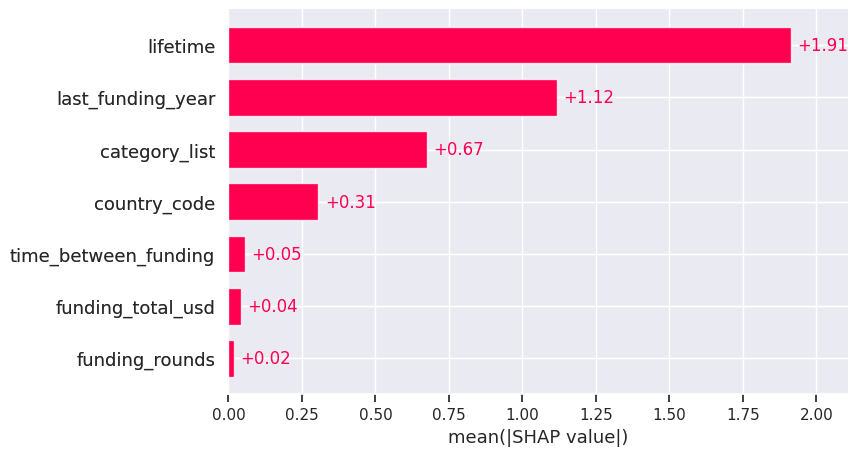

In [124]:
shap.plots.bar(shap_values)

**Вывод**
    
Больше всего на прогнозы модели влияют следующие признаки:
- `lifetime` - признак с наибольшим влиянием;
- `last_funding_year`;
- `category_list`;
- `country_code`;
    
В меньшей степени на прогноз модели влияют признаки:
    
- `time_between_funding`;
- `funding_total_usd`;
- `funding_rounds`
    
Можно заключить, что модель сочла срок жизни стартапа наиболее ценной для построения прогноза, тогда как сумма и особенности процесса финансирования стартапа влияют на решение модели в значительно меньшей степени.

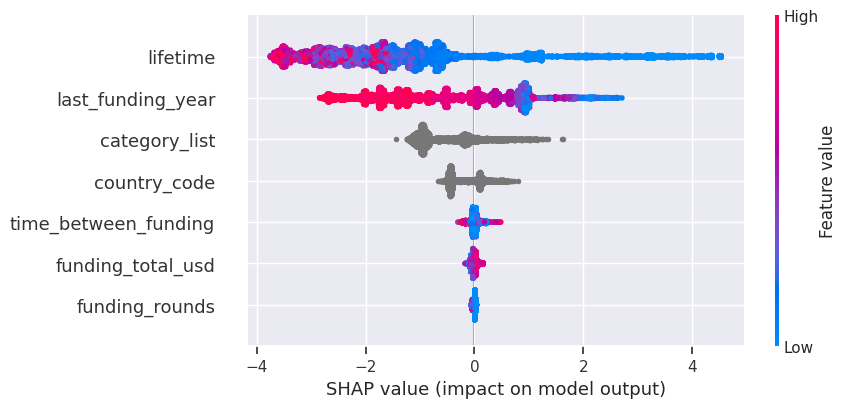

In [125]:
shap.plots.beeswarm(shap_values)

**Вывод:**

Расшифруем полученные результаты:

- признак `lifetime`:

низкое количество дней существования стартапа по соображениям модели говорит о том, что компания с бóльшей вероятностью закроется в ближайшее время в сравнении со стартапами, осуществляющими деятельность в течение долгого времени;

- признак `last_funding_year`:
    
бóльший (недавний) год последнего раунда финансирования относит стартап к категории  `0`  и говорит о предполагаемом успехе компании. Стартапам, давно не получавшим финансирование, модель с бóльшей вероятностью прогнозирует скорое закрытие;
    
- признаки `category_list` и `country_code`:
    
категориальные признаки;
    
- признак `time_between_funding`:
    
длительный срок финансирования компании относит стартап к обеим категориям с примерно  равной вероятностью. При этом короткий срок финансирования практически не влияет на прогноз модели;
    
- признаки `funding_total_usd` и `funding_rounds`:
практически не влияют на прогноз модели.
      
Из полученных результатов можно сделать вывод, что при построении прогноза модель в первую очередь опирается на срок жизни стартапов как в целом, так и после завершения финансирования и считает компании, просуществовавшие уже длительное время и недавно получившие финансирование, более перспективными.

### Заключение

**Описание**

Для проведения исследования получены данные о стартапах, функционировавших в период с 1970 по 2018 годы.

Необходимо построить модель, которая поможет предсказать, закроется ли стартап.

---

**Изучение данных**

Перед проведением исследования данные были изучены:

- импортированы соответствующие библиотеки;
- считаны датасеты с данными о стартапах;
- изучена общая информация о полученных данных.

---

**Предобработка данных**

Проведена предобработка данных:

- Проверены типы данных;
- Изучены и обработаны пропуски в датафреймах;
- Проверены и обработаны дубликаты в датафреймах, в том числе и неявные.

Снижена кардинальность признака `category_list` c использованием TF-IDF.

В ходе проверки дубликатов также обнаружено, что значения столбца `state_code` не уникальны. Данный столбец удалён.

---

**Исследовательский анализ данных**

Проведён исследовательский анализ всех признаков тренировочного датафрейма.

Для построения визуализаций написаны собственные функции.

    - Признак "funding_total_usd"

Признак распределён нормально, большинство значений располагается в промежутке от 442 413 до 8 886 110 USD.

Выбросы и аномалии в данных отсутствуют.

    -  Признак "funding_rounds"

Распределение признака асимметрично вправо, большинство значений располагается в промежутке от 1 до 2 раундов.

Выбросы и аномалии в данных отсутствуют.

     - Признак "status"

Признак представлен категориями:

- 0 «operating»
- 1 «closed»

В выборке преобладает статус «operating». Целевой признак не сбалансирован, учтём это при формировании обучающей выборки для модели.

     - Признак "country_code"

Наиболее распростарнённая страна расположения стартапа - США.

В топ-5 также вошли следующие страны:
- Великобритания;
- Канада;
- Индия;
- Китай.

В данных странах зарегистрировано более 1000 стартапов по данным исследуемой выборки.

     - Признак "region"

Самый частый регион расположения стартапа - область залива Сан-Франциско, США.

В список лидеров также вошли следующие регионы:

- Нью-Йорк, США;
- Бостон, США;
- Лондон, Великобритания;
- Лос-Анджелес, США.

В данных регионах зарегистрировано более 1000 стартапов по данным исследуемой выборки.

     - Признак "city"

Самый частый город расположения стартапа - Сан-Франциско.

В список лидеров также вошли следующие города:

- Нью-Йорк;
- Лондон.

В данных городах зарегистрировано более 1000 стартапов по данным исследуемой выборки.

     - Признак "category_list"

Наиболее популярными категориями деятельности стартапов являются:

- Software;
- Biotechnology;
- E-Commerce;
- Mobile;
- Clean Technology;
- Curated Web;
- Health Care;
- Hardware + Software;
- Games;
- Enterprise Software

Категории Software и Biotechnology лидируют в популярности со значительным отрывом.

     - Признак "founded_at"

Визуализация показала заметный рост количества открытых стартапов к 2000 году, пик которого пришёлся на 2015 год.

     - Признак "first_funding_at"

Рост начала финансирования стартапов отмечается к 2000 году и достигает своего пика в 2014 году, что совпадает с динамикой роста открытия стартапов.

     - Признак "last_funding_at"

Визуализация отобразила постепенный рост завершающих раундов финансирования с 2000 по 2015 годы с большим скачком в 2014 году.

     - Признак "closed_at"

На визуализации отмечается резкий скачок количества закрытых стартапов в 2008 году с последующим увеличением до максимального числа закрытых стартапов в 2017 году.

Резкий рост числа закрытых стартапов в 2008 году может быть связан с Мировым экономическим кризисом.

---

**Добавление признаков**

В целях проведения исследования были добавлены дополнительные столбцы:

- столбец `lifetime`, содержащий срок существования стартапа в днях;
- столбец `founded_at_year`, содержащий  год основания стартапа;
- столбец `lifetime_before_funding`, содержащий срок существования стартапа до первого раунда финансирования;
- столбец `first_funding_year`, содержащий год начала финансирования стартапа;
- столбец `last_funding_year`, содержащий год последнего раунда финансирования;
- столбец  `time_between_funding` со сроком полного цикла финансирования стартапа: сколько дней прошло между первым и последним раундом финансирования.

Добавление дополнительных признаков помогло уменьшить кардинальность некоторых признаков, найти некорректные данные в выборке, а также будет использовано для поиска закономерностей в дальнейшем исследовании.

---

**Корреляционный анализ**

Проведён корреляционный анализ признаков тренировочного датафрейма.

Признак `status` - целевой, дополнительно изучена взаимосвязь входных признаков с целевым, а также выборка проверена на наличие мультиколлинеарности признакового описания.

    - Матрица корреляции
Корреляция признаков рассмотрена с помощью матрицы корреляций `phik_matrix()`.

При первом построении матрицы `phik` выявлена мультиколлинеарность признакового описания.

На основании показателей корреляции в тренировочном датафрейме были отобраны признаки для дальнейшего обучения модели.

Умеренная зависимость с целевым выявлена признака `lifetime`.

Мультиколлинеарность отобранных входных признаков отсутствует.

    - Целевой признак

Дополнительно изучена сопряжённость целевого признака `status` и входных признаков датафрейма с помощью собственных функций.

- признак "funding_total_usd"

Сумма финансирования действующих и закрытых компаний однородна: наиболее часто встречаемое значение в 1 202 604 USD соответствует обоим статусам стартапов.

- признак "funding_rounds"

Можно отметить, что наиболее часто встречающееся количество раундов финансирования совпадает для обоих статусов стартапов - 1 раунд.

При этом, действующие стартапы получают больше раундов финансирования.

- признак "lifetime"

Действующим стартапам соответствует бóльший срок жизни: в среднем 7-9 лет.

Продолжительность деятельности закрытых стартапов - 3-4 года.

---

**Обучение моделей**

Для решения задачи выбраны две модели:

- `RandomForestClassifier()`;
- `CatBoostClassifier()`.

Каждую из моделей решено обучить на двух наборах данных:
-  только на тренировочной выборке;
-  на расширенной выборке с добавлением матрицы признаков деятельности стартапов.

Выбор модели для прогноза будет осуществляться на основе метрики `F1-Score`.

    - модель RandomForestClassifier()

- **на тренировочной выборке**

Написан пайплайн для модели `RandomForestClassifier()` с подбором гиперпараметров, который определил лучшую конфигурацию модели с помощью метрики `F1-Score`.

Модель обучена на данных тренировочной выборки.

Результат работы модели удовлетворительный:

- Метрика на кросс-валидационной выборке: 0.9979350775614033;
- Метрика на валидационной выборке: 0.8451601113081869

- **+ tfidf features**

Написан пайплайн для модели `RandomForestClassifier()` с подбором гиперпараметров, который определил лучшую конфигурацию модели с помощью метрики `F1-Score`.

Модель обучена на данных тренировочной выборки с добавлением матрицы категорий деятельности стартапов.

Результат работы модели удовлетворительный:

- Метрика на кросс-валидационной выборке: 0.9746049792944202;
- Метрика на валидационной выборке: 0.7304454908150941

    - модель CatBoostClassifier()

- **на тренировочной выборке**

Построена модель `CatBoostClassifier()` с оценкой качества метрикой `F1-Score`.

Модель обучена на данных тренировочной выборки.

Результат работы модели удовлетворительный:

- Метрика на кросс-валидационной выборке: 0.97;
- Метрика на валидационной выборке: 0.97

- **+ tfidf features**

Построена вторая модель `CatBoostClassifier()` с оценкой качества метрикой `F1-Score`.

Модель обучена на данных тренировочной выборки с добавлением матрицы признаков деятельности стартапа.

Результат работы модели удовлетворительный:

- Метрика на кросс-валидационной выборке: 0.97;
- Метрика на валидационной выборке: 0.97130

---

**Выбор лучшей модели**

В данном шаге исследования выбрана модель для построения прогноза. Качество моделей оценено с помощью метрики `F1-Score`.

- Метрика модели `RandomForestClassifier()` на тренировочной выборке:
CV score: 0.84516


- Метрика модели `RandomForestClassifier()` на тренировочной выборке + tfid:
CV score: 0.63669


- Метрика модели `CatBoostClassifier()` на тренировочной выборке:
CV score: 0.97588


- Метрика модели `CatBoostClassifier()` на тренировочной выборке + tfid:
CV score: 0.97130


На кросс-валидации и валидационной выборке лучше всего показала себя модель `CatBoostClassifier()`, обученная только на данных тренировочной выборки.

Метрика `F1-Score` лучшей модели составила 0.97207.

Для получения прогноза выбрана данная модель. Прогноз закрытия стартапа получен на данных тестовой выборки.

---

**Анализ важности признаков**

Важность признаков лучшей модели изучена с помощью метода `SHAP`.

Для визуализации вклада признаков в предсказание модели построены диаграммы `shap.plots.bar` и `shap.plots.beeswarm`.

Больше всего на прогнозы модели влияют следующие признаки:

- lifetime - признак с наибольшим влиянием;
- last_funding_year;
- category_list;
- country_code

В меньшей степени на прогноз модели влияют признаки:
- time_between_funding;
- funding_total_usd;
- funding_rounds

Можно заключить, что модель сочла срок жизни стартапа наиболее ценной для построения прогноза, тогда как сумма и особенности процесса финансирования стартапа влияют на решение модели в значительно меньшей степени.

Расшифруем полученные результаты:

- признак `lifetime`:
низкое количество дней существования стартапа по соображениям модели говорит о том, что компания с бóльшей вероятностью закроется в ближайшее время в сравнении со стартапами, осуществляющими деятельность в течение долгого времени;

- признак `last_funding_year`:
бóльший (недавний) год последнего раунда финансирования относит стартап к категории 0 и говорит о предполагаемом успехе компании. Стартапам, давно не получавшим финансирование, модель с бóльшей вероятностью прогнозирует скорое закрытие;

- признак `time_between_funding`:
длительный срок финансирования компании относит стартап к обеим категориям с примерно равной вероятностью. При этом короткий срок финансирования практически не влияет на прогноз модели;

- признаки `funding_total_usd` и `funding_rounds`: практически не влияют на прогноз модели.

Из полученных результатов можно сделать вывод, что при построении прогноза модель в первую очередь опирается на срок жизни стартапов как в целом, так и после завершения финансирования и считает компании, просуществовавшие уже длительное время и недавно получившие финансирование, более перспективными.
